# 1. Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.stats.proportion as proportion
import statsmodels.stats.power as smp

from scipy import stats
from math import sqrt

# 2. Загрузка данных по событиям на сайте в рамках одного визита (hits) 

In [3]:
hits = pd.read_csv('ga_hits-002.csv')

In [4]:
hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      object 
 1   hit_date        object 
 2   hit_time        float64
 3   hit_number      int64  
 4   hit_type        object 
 5   hit_referer     object 
 6   hit_page_path   object 
 7   event_category  object 
 8   event_action    object 
 9   event_label     object 
 10  event_value     float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


In [5]:
hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [6]:
# Создадим копию для исходного датафрейма
hits_copy = hits.copy()

# 3. Data Preparation for hits

## 3.1. Обработка неинформативных признаков и пустых значений

Сделаем небольшую сводку, которая опишет данные таблицы: уникальные значения для каждого признака, количество строк с ними во всём признаке, а также тип данных.

In [7]:
for hits_feature in hits_copy.columns.to_list():
    print(f'{hits_copy[hits_feature].value_counts(dropna=False)}\n\n\n')

5442565791571325612.1632449195.1632449195    768
6568868914238486437.1632270313.1632270313    678
5959671972744778783.1632490527.1632490600    548
7452598043578978502.1632358598.1632358598    514
3070792010704358528.1629752408.1629752408    498
                                            ... 
4570994095441102117.1630324006.1630324006      1
768506153535315810.1630314342.1630314342       1
5517253735248338264.1630315080.1630315080      1
4054272189286640867.1630334209.1630334209      1
5381267721977892188.1640271196.1640271196      1
Name: session_id, Length: 1734610, dtype: int64



2021-05-24    513035
2021-12-21    280192
2021-05-25    235805
2021-09-23    168899
2021-05-26    158382
               ...  
2021-07-24     23490
2021-05-23     18773
2021-05-19     14605
2021-05-22     13917
2021-05-21     13497
Name: hit_date, Length: 226, dtype: int64



NaN          9160322
0.0            41137
1.0            18522
2.0            10101
3.0             6060
              ...   
544067.0

Проверим пустые значений в колонках.

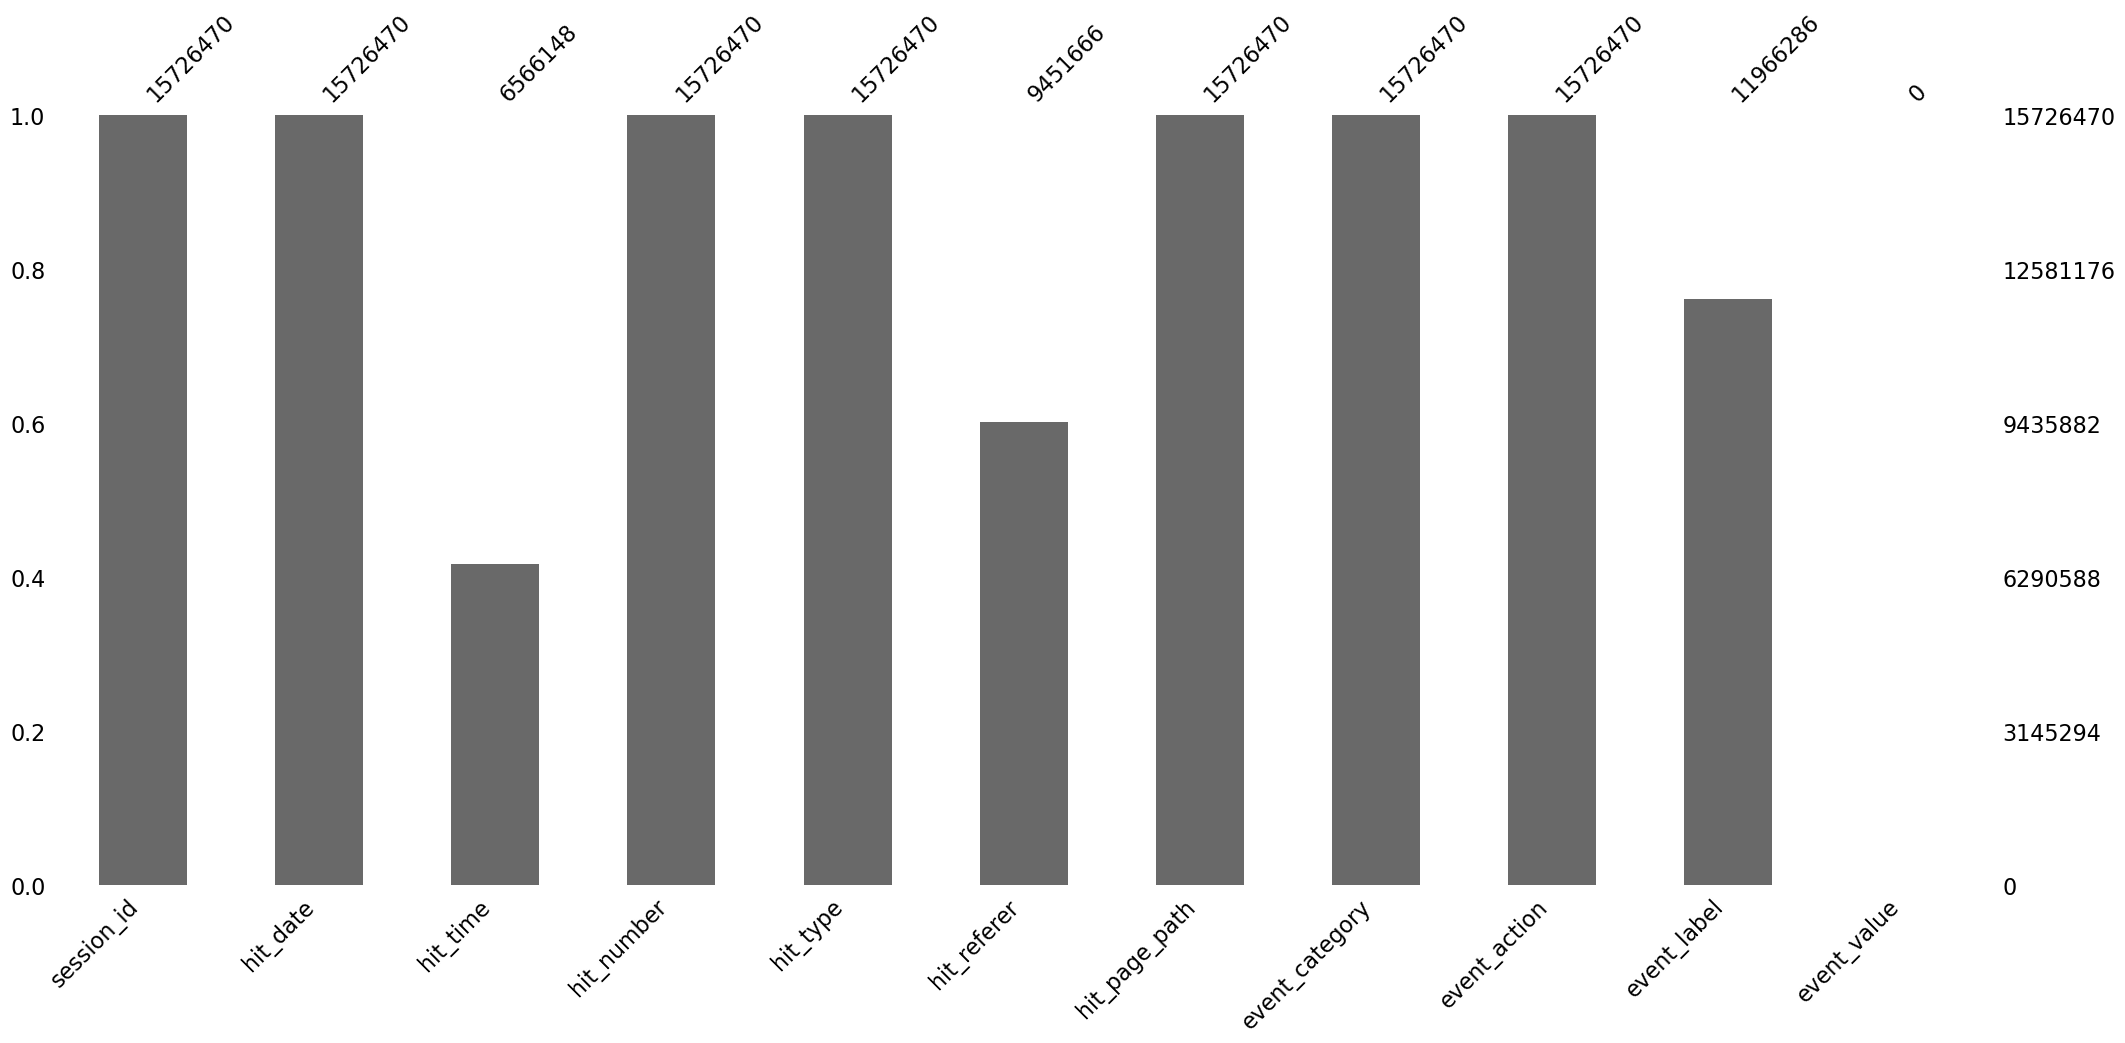

In [8]:
# Построим график, наглядно демонстрирующий заполненность признаков в таблице.
msno.bar(hits_copy);

In [9]:
# Построим таблицу, показывающую сколько процентов пустых значений содержит каждый признак. 
((hits_copy.isna().sum()/len(hits_copy))*100).sort_values(ascending=False)

event_value       100.000000
hit_time           58.247795
hit_referer        39.899634
event_label        23.909905
session_id          0.000000
hit_date            0.000000
hit_number          0.000000
hit_type            0.000000
hit_page_path       0.000000
event_category      0.000000
event_action        0.000000
dtype: float64

Опираясь на сводки и графики выше, можно заметить: в таблице есть неинформативные и малоинформативные признаки, которые не имеют значимости для расчётов, а главное, не влияют на ответы на вопросы продуктовой команды.

1) 'hit_time' (время события) - не связано с поставленными вопросами, высокий процент пропусков (58%).

2) 'hit_number' (порядковый номер события) - не связано с поставленными вопросами.

3) 'hit_type' (тип события) - одно единственное значение 'event' на все строки таблицы - не имеет смысла.

4) 'hit_referer' (источник события) - высокий процент пропусков (ок.40%); много специфичных уникальных значений, не имеющие пояснений.

5) 'event_category' (тип действия) - не связано с поставленными вопросами. 

6) 'event_label' (тэг действия) - высокий процент пропусков (ок.24%); много специфичных уникальных значений, не имеющих пояснений.

7) 'event_value' (значение результата действия) - полностью пустой признак.

Перечисленные столбцы можно удалить.

In [10]:
hits_columns_to_drop = ['hit_time','hit_number', 'hit_type', 'hit_referer', 'event_category', 'event_label', 'event_value']
for del_hits_param in hits_columns_to_drop:
    del hits_copy[del_hits_param]

## 3.2. Проверка полных дубликатов

In [11]:
# Вывод таблицы со строками, совпадающими на 100%
hits_copy[hits_copy.duplicated()]

,session_id,hit_date,hit_page_path,event_action
23,3117547552978670057.1640217454.1640217454,2021-12-23,sberauto.com/cars/all/skoda/rapid/bf24b977?ren...,view_card
32,3282323002617677961.1640266499.1640266499,2021-12-23,sberauto.com/cars/all/lada-vaz/vesta/2fc745ed?...,view_card
39,562366956183957396.1640246520.1640246520,2021-12-23,sberauto.com/cars/all/mini/hatch/b82590a3?rent...,view_card
42,628849304731384746.1640233987.1640233987,2021-12-23,sberauto.com/cars/all/skoda/rapid/bf24b977?ren...,view_card
61,2530706414478031710.1640233887.1640233887,2021-12-23,sberauto.com/cars/all/nissan/qashqai/bfc21661?...,view_card
...,...,...,...,...
15726416,2445898965208837590.1640279515.1640279515,2021-12-23,sberauto.com/cars/all/kia/sorento/c38179cb?utm...,photos
15726420,1279681186746345207.1640244983.1640244983,2021-12-23,sberauto.com/cars/all/skoda/rapid/bf24b977?utm...,photos
15726421,1279681186746345207.1640244983.1640244983,2021-12-23,sberauto.com/cars/all/renault/logan/8c3c73f2?u...,photos
15726429,2233243198661178069.1640255986.1640255986,2021-12-23,sberauto.com/cars?utm_source_initial=outlook&u...,quiz_show


In [12]:
# Удалим дубликаты, перезапишем переменную hits_copy
hits_copy = hits_copy.drop_duplicates()

## 3.3. Создание новых признаков на основе имеющейся информации

По условию: если один пользователь при посещении сайта совершает целевое действие (из target_action_list - см. ниже) несколько раз, то такие записи считаются за одну. 

Значит, если для конкретного id в колонке event_action встречается что-то из целевого действия, то все остальные строки таблицы с этим id (где в event_action могут стоять другие целевые действия или даже нецелевые) можно удалить как повторы.

Отсюда же можно сделать вывод, что все целевые действия обладают одним и тем же весом. Также как и все нецелевые. Следовательно, можно создать новый признак (target_action), в формате, где будут только 2 значения: 1 - целевое действие было в истории конкретного id, 0 - не было.

In [13]:
target_action_list = ['sub_car_claim_click', 'sub_car_claim_submit_click',
                      'sub_open_dialog_click', 'sub_custom_question_submit_click',
                      'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
                      'sub_car_request_submit_click']

In [14]:
hits_copy['target_action'] = hits_copy['event_action'].apply(lambda x: 1 if (x in target_action_list) else 0)

Стоит обратить внимание на колонку hit_page_path (страница события), где среди большой ссылки встречаются наименования производителей и моделей автомобилей. Создадим два новых признака: 'car_manufacturer' и 'car_model', в которые отдельно вынесем названия.

In [15]:
hits_copy['car_manufacturer'] = hits_copy['hit_page_path'].apply(lambda x: x.split('cars/all/')[-1].split('/')[0] if 'cars/all/' in x else '-')

In [16]:
hits_copy['car_model'] = hits_copy['hit_page_path'].apply(lambda x: (x.split('cars/all/')[-1].split('/')[0] + ' ' + x.split('cars/all/')[-1].split('/')[1]) if 'cars/all/' in x else '-')

Ещё на себя обращает внимание колонка 'hit_date' с форматом значений 'int' (целые числа). Исправим в формат для дат.

In [17]:
hits_copy['date'] = pd.to_datetime(hits_copy.hit_date)

Теперь 'hit_page_path', 'hit_date', 'event_action' тоже можно удалить. 

In [18]:
for del_hits_param in 'hit_page_path', 'hit_date', 'event_action':
    del hits_copy[del_hits_param]

Посмотрим, как выглядит таблица hits_copy сейчас.

In [19]:
hits_copy.head()

,session_id,target_action,car_manufacturer,car_model,date
0,5639623078712724064.1640254056.1640254056,0,-,-,2021-12-23
1,7750352294969115059.1640271109.1640271109,0,-,-,2021-12-23
2,885342191847998240.1640235807.1640235807,0,volkswagen,volkswagen polo,2021-12-23
3,142526202120934167.1640211014.1640211014,0,-,-,2021-12-23
4,3450086108837475701.1640265078.1640265078,0,mercedes-benz,mercedes-benz cla-klasse,2021-12-23


После преобразований таблица сильно изменилась. Вероятно, что появились новые строки-дубликаты. Проверим.

In [20]:
hits_copy[hits_copy.duplicated()]

,session_id,target_action,car_manufacturer,car_model,date
1402,3450086108837475701.1640265078.1640265078,0,mercedes-benz,mercedes-benz cla-klasse,2021-12-23
1503,1187487192585096450.1640259719.1640259734,0,volkswagen,volkswagen passat-cc,2021-12-23
1573,6806339404093975583.1640229920.1640229920,0,mercedes-benz,mercedes-benz glb,2021-12-23
1614,8325336351616827054.1640267437.1640267437,0,volkswagen,volkswagen polo,2021-12-23
1617,3102198263282190785.1640286700.1640286700,0,skoda,skoda rapid,2021-12-23
...,...,...,...,...,...
15726465,6866159858916559617.1640270865.1640270865,0,toyota,toyota fortuner,2021-12-23
15726466,7310304587364460692.1640261783.1640261783,0,mercedes-benz,mercedes-benz gla-klasse,2021-12-23
15726467,8013702685784312179.1640270195.1640270195,0,toyota,toyota alphard,2021-12-23
15726468,8021505554734405918.1640257821.1640257821,0,bmw,bmw x3,2021-12-23


Действительно, появились новые дубликаты. Удалим их.

In [21]:
hits_copy = hits_copy.drop_duplicates()

In [22]:
hits_copy

,session_id,target_action,car_manufacturer,car_model,date
0,5639623078712724064.1640254056.1640254056,0,-,-,2021-12-23
1,7750352294969115059.1640271109.1640271109,0,-,-,2021-12-23
2,885342191847998240.1640235807.1640235807,0,volkswagen,volkswagen polo,2021-12-23
3,142526202120934167.1640211014.1640211014,0,-,-,2021-12-23
4,3450086108837475701.1640265078.1640265078,0,mercedes-benz,mercedes-benz cla-klasse,2021-12-23
...,...,...,...,...,...
15726428,9133986343066795570.1640237559.1640237559,0,nissan,nissan qashqai,2021-12-23
15726430,9085314742876382341.1640264820.1640264820,0,-,-,2021-12-23
15726431,1009509786569589790.1640244938.1640244938,0,-,-,2021-12-23
15726432,5381267721977892188.1640271196.1640271196,0,-,-,2021-12-23


## 3.4. Создание сводной таблицы

На сводке выше было видно, что число уникальныых значений для session_id в таблице равно 1 734 610. При этом число записей в очищенной таблице  ок. 2.1 млн. Так может быть потому, что посетители сайта могли за один визит совершить как целевое, так и не целевое действие, из-за чего заносились в таблицу дважды. Создадим сводную таблицу по session_id, чтобы это исправить.

In [23]:
hits_copy = hits_copy.groupby(['session_id'], as_index = False).agg({
    'date' : 'first', # дата визита
    'car_manufacturer' : 'max', # производитель (если есть информация)
    'car_model' : 'max', # модель машины (если есть информация)
    'target_action' : 'max' # было ли целевое действие в истории клиента
})

Сразу переименуем колонки сводной таблицы для удобства восприятия.

In [24]:
hits_copy.columns = ['session_id', 'date', 'manufacturer', 'model', 'target_action']

In [25]:
hits_copy

,session_id,date,manufacturer,model,target_action
0,1000009318903347362.1632663668.1632663668,2021-09-26,-,-,0
1,1000010177899156286.1635013443.1635013443,2021-10-23,-,-,0
2,1000013386240115915.1635402956.1635402956,2021-10-28,lada-vaz,lada-vaz vesta,0
3,1000017303238376207.1623489300.1623489300,2021-06-12,-,-,0
4,1000020580299877109.1624943350.1624943350,2021-06-29,-,-,0
...,...,...,...,...,...
1734605,999960188766601545.1626816843.1626816843,2021-07-21,-,-,0
1734606,99996598443387715.1626811203.1626811203,2021-07-20,-,-,0
1734607,999966717128502952.1638428330.1638428330,2021-12-02,-,-,0
1734608,999988617151873171.1623556243.1623556243,2021-06-13,-,-,0


# 4. Загрузка данных по визитам на сайт (sessions)

In [26]:
sessions = pd.read_csv('skillbox_diploma_main_dataset_sberautopodpiska/ga_sessions.csv')

In [27]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   utm_keyword               object
 10  device_category           object
 11  device_os                 object
 12  device_brand              object
 13  device_model              object
 14  device_screen_resolution  object
 15  device_browser            object
 16  geo_country               object
 17  geo_city                  object
dtypes: int64(1), object(17)
memory usage: 255.4+ MB


In [28]:
sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [29]:
# Создадим копию для исходного датафрейма
sessions_copy = sessions.copy()

# 5. Data Preparation for sessions

## 5.1. Обработка неинформативных признаков

Сделаем небольшую сводку, которая опишет данные таблицы: уникальные значения для каждого признака, количество строк с ними во всём признаке, а также тип данных.

In [30]:
for sessions_feature in sessions_copy.columns.to_list():
    print(f'{sessions_copy[sessions_feature].value_counts(dropna=False)}\n\n\n')

9055434745589932991.1637753792.1637753792    1
6294640354816492625.1638728787.1638728809    1
6294832296889291185.1623245519.1623245519    1
6294832296889291185.1623161065.1623161065    1
6294832296889291185.1623156608.1623156608    1
                                            ..
3525580570051063315.1625927189.1625927189    1
3525573324456022940.1640876964.1640876964    1
3525573324456022940.1640837067.1640837067    1
3525573324456022940.1640715164.1640715164    1
9055430416266113553.1640968742.1640968742    1
Name: session_id, Length: 1860042, dtype: int64



1.750498e+09    462
1.309184e+08    334
1.266575e+09    309
7.368596e+08    306
1.894772e+09    276
               ... 
8.789419e+08      1
8.789399e+08      1
8.789397e+08      1
8.789339e+08      1
2.108382e+09      1
Name: client_id, Length: 1391717, dtype: int64



2021-05-24    39453
2021-12-21    30704
2021-05-25    19305
2021-06-29    17367
2021-09-14    16204
              ...  
2021-06-05     2102
2021-05-23     1246
20

Проверим пустые значений в колонках.

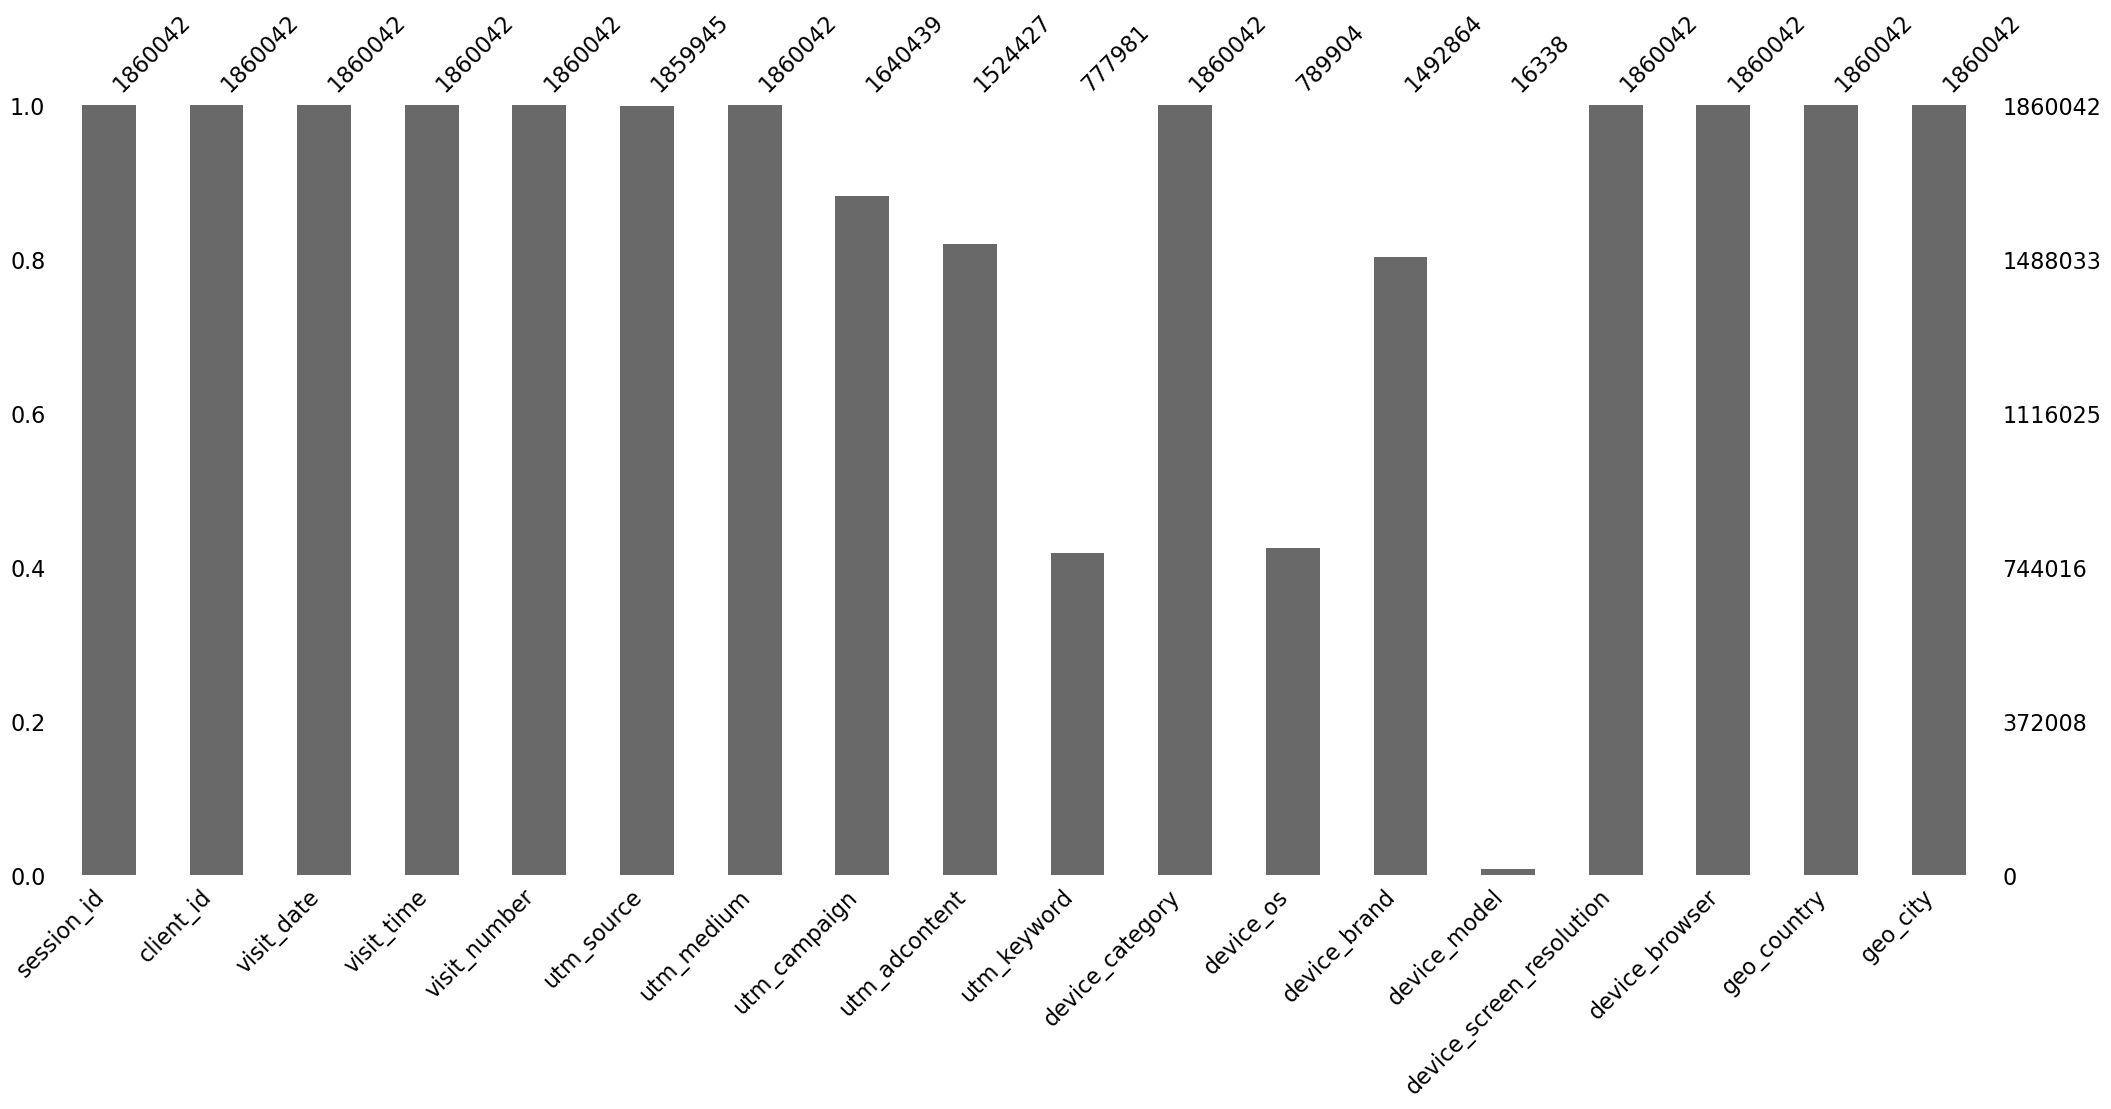

In [31]:
# Построим график, наглядно демонстрирующий заполненность признаков в таблице.
msno.bar(sessions_copy);

In [32]:
# Построим таблицу, показывающую сколько процентов пустых значений содержит каждый признак. 
((sessions_copy.isna().sum()/len(sessions_copy))*100).sort_values(ascending=False)

device_model                99.121633
utm_keyword                 58.174009
device_os                   57.533002
device_brand                19.740307
utm_adcontent               18.043410
utm_campaign                11.806346
utm_source                   0.005215
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
session_id                   0.000000
device_category              0.000000
client_id                    0.000000
utm_medium                   0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
geo_city                     0.000000
dtype: float64

Опираясь на сводки и графики выше, можно заметить: в таблице есть неинформативные и малоинформативные признаки, которые не имеют значимости для расчётов, а главное, не влияют на ответы на вопросы продуктовой команды.

1) 'visit_time' (время визита) - не связано с поставленными вопросами;

2) 'visit_number' (порядковый номер визита клиента) - не связано с поставленными вопросами;

3) 'utm_keyword' (ключевое слово) - высокий процент пропусков (58%); много специфичных уникальных значений, не имеющих пояснений. Не связано с поставленными вопросами;

4) 'device_os' (ОС устройства) - высокий процент пропусков (57%); не имеет отношения к поставленным вопросам;

5) 'device_model' (модель устройства) - 99% пустых значений, не связано с поставленными вопросами;

6) 'utm_adcontent' - нет пояснений, много специфичных значений;

7) 'utm_campaign' - специфические значения без пояснений, не связано с поставленными вопросами;

8) 'device_screen_resolution' (разрешение экрана) - не связано с поставленными вопросами.

Перечисленные столбцы можно удалить.

In [33]:
sessions_columns_to_drop = ['visit_time','visit_number', 'utm_keyword', 'device_os', 'device_model', 'utm_adcontent', 'utm_campaign', 'device_screen_resolution']
for del_sessions_param in sessions_columns_to_drop:
    del sessions_copy[del_sessions_param]

## 5.2. Обработка пустых значений

In [34]:
# В признаке utm_source есть пропуски (NaN). В device_brand - 'None'. Обработаем их.
for sessions_param in 'utm_source', 'device_brand':
    sessions_copy[sessions_param + '_corrected'] = sessions[sessions_param].apply(lambda x: 'other' if (type(x) == float) or (x == None) else x)
    del sessions_copy[sessions_param]

In [35]:
# Проверим, что получилось:
sessions_copy

,session_id,client_id,visit_date,utm_medium,device_category,device_browser,geo_country,geo_city,utm_source_corrected,device_brand_corrected
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,banner,mobile,Chrome,Russia,Zlatoust,ZpYIoDJMcFzVoPFsHGJL,Huawei
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,cpm,mobile,Samsung Internet,Russia,Moscow,MvfHsxITijuriZxsqZqt,Samsung
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,banner,mobile,Chrome,Russia,Krasnoyarsk,ZpYIoDJMcFzVoPFsHGJL,Huawei
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,cpc,mobile,Chrome,Russia,Moscow,kjsLglQLzykiRbcDiGcD,Xiaomi
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,cpc,mobile,Chrome,Russia,Moscow,kjsLglQLzykiRbcDiGcD,Xiaomi
...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.164016,2021-12-22,cpc,desktop,Chrome,Russia,Moscow,BHcvLfOaCWvWTykYqHVe,other
1860038,9055421130527858185.1622007305.1622007305,2108379530.162201,2021-05-26,(none),mobile,Safari,Russia,Stavropol,fDLlAcSmythWSCVMvqvL,Apple
1860039,9055422955903931195.1636979515.1636979515,2108379955.163697,2021-11-15,(none),mobile,Safari,Russia,Moscow,fDLlAcSmythWSCVMvqvL,Apple
1860040,905543020766873816.1638189404.1638189404,210838164.163819,2021-11-29,banner,mobile,Chrome,Russia,Chelyabinsk,ZpYIoDJMcFzVoPFsHGJL,Xiaomi


In [36]:
((sessions_copy.isna().sum()/len(sessions_copy))*100).sort_values(ascending=False)

session_id                0.0
client_id                 0.0
visit_date                0.0
utm_medium                0.0
device_category           0.0
device_browser            0.0
geo_country               0.0
geo_city                  0.0
utm_source_corrected      0.0
device_brand_corrected    0.0
dtype: float64

## 5.3. Проверка полных дубликатов

In [37]:
sessions_copy[sessions_copy.duplicated()]

,session_id,client_id,visit_date,utm_medium,device_category,device_browser,geo_country,geo_city,utm_source_corrected,device_brand_corrected


В таблице визитов на сайт нет повторяющихся строк.

## 5.4. Выгрузка и обработка сторонних данных

Заметно, что в таблице есть данные о стране и населённом пункте. При этом нет данных о регионе РФ, в котором живёт посетитель сайта (если посетитель находится в России). Поскольку продуктовая команда спрашивает про самый целевой трафик по локациям, в частности про города-присутствия в Московской области, то понадобятся дополнительные данные: готовая таблица населённых пунктов с регионами РФ из страницы Википедии.

In [38]:
table_from_wikipedia = pd.read_html('https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Russia')[0]
table_from_wikipedia.head()

,City,Russian name,Federal subject
0,Abakan,Абакан,Republic of Khakassia
1,Abaza,Абаза,Republic of Khakassia
2,Abdulino,Абдулино,Orenburg Oblast
3,Abinsk,Абинск,Krasnodar Krai
4,Achinsk,Ачинск,Krasnoyarsk Krai


In [39]:
# Немного внешних исправлений:
table_from_wikipedia = table_from_wikipedia.loc[:,['Federal subject','City']]
table_from_wikipedia.columns = ['russian_federal_subject', 'geo_city']

In [40]:
table_from_wikipedia

,russian_federal_subject,geo_city
0,Republic of Khakassia,Abakan
1,Republic of Khakassia,Abaza
2,Orenburg Oblast,Abdulino
3,Krasnodar Krai,Abinsk
4,Krasnoyarsk Krai,Achinsk
...,...,...
1108,Tver Oblast,Zubtsov
1109,Kirov Oblast,Zuyevka
1110,Moscow Oblast,Zvenigorod
1111,Mari El,Zvenigovo


In [41]:
# Проверим, всё ли в порядке с названиями регионов
table_from_wikipedia.russian_federal_subject.unique()

array(['Republic of Khakassia', 'Orenburg Oblast', 'Krasnodar Krai',
       'Krasnoyarsk Krai', 'Republic of Adygea',
       'Republic of Bashkortostan', 'Republic of Tatarstan',
       'Tuva Republic', 'Astrakhan Oblast', 'Rostov Oblast',
       'Republic of North Ossetia–Alania', 'Sverdlovsk Oblast',
       'Chuvash Republic', 'Sakha Republic', 'Tula Oblast',
       'Vladimir Oblast', 'Perm Krai', 'Sakhalin Oblast',
       'Belgorod Oblast', 'Altai Krai', 'Irkutsk Oblast',
       'Khabarovsk Krai', 'Chukotka Autonomous Okrug', 'Tver Oblast',
       'Kemerovo Oblast', 'Murmansk Oblast', 'Moscow Oblast',
       'Republic of Mordovia', 'Chechen Republic', 'Saratov Oblast',
       'Arkhangelsk Oblast', 'Primorsky Krai', 'Republic of Tatarstan[1]',
       'Nizhny Novgorod Oblast', 'Chelyabinsk Oblast', 'Tomsk Oblast',
       'Vologda Oblast', 'Republic of Buryatia', 'Kaliningrad Oblast',
       'Kabardino-Balkar Republic', 'Kaluga Oblast', 'Zabaykalsky Krai',
       'Novosibirsk Oblast', 

Замечено, что списке регионов встречается значение 'Republic of Tatarstan[1]' (в таблицу с сайта попала гиперссылка на примечание). Поправим это на значение 'Republic of Tatarstan'

In [42]:
for ind in range(len(table_from_wikipedia)):
    if (table_from_wikipedia['russian_federal_subject'] == 'Republic of Tatarstan[1]')[ind] == True:
        table_from_wikipedia['russian_federal_subject'][ind] = 'Republic of Tatarstan'

Сейчас посмотрим, встречаются ли в России города с одинаковыми названиями, но принадлежащие разным субъектам.

In [43]:
cities_duplicates = table_from_wikipedia[table_from_wikipedia.geo_city.duplicated()]
cities_duplicates

,russian_federal_subject,geo_city
91,Sverdlovsk Oblast,Berezovsky
103,Republic of Bashkortostan,Blagoveshchensk
205,Primorsky Krai,Fokino
242,Kemerovo Oblast,Guryevsk
334,Kirov Oblast,Kirov
338,Murmansk Oblast,Kirovsk
392,Saratov Oblast,Krasnoarmeysk
398,Republic of Mordovia,Krasnoslobodsk
407,Moscow Oblast,Krasnoznamensk
517,Stavropol Krai,Mikhaylovsk


In [44]:
cities_duplicates.shape

(21, 2)

Можно заметить, что таких населённых пунктов 21. Чтобы не возникало путанницы, города-тезки лучше удалить из списка, а позже в строки из таблицы sessions в колонку 'geo_city' подставить значение 'other'.

In [45]:
for index_city in range(len(table_from_wikipedia)):
    if table_from_wikipedia.geo_city[index_city] in cities_duplicates.geo_city.to_list():
        table_from_wikipedia.iloc[index_city,0:2] = None, None

In [46]:
table_from_wikipedia = table_from_wikipedia[table_from_wikipedia.geo_city.notna()]

In [47]:
table_from_wikipedia

,russian_federal_subject,geo_city
0,Republic of Khakassia,Abakan
1,Republic of Khakassia,Abaza
2,Orenburg Oblast,Abdulino
3,Krasnodar Krai,Abinsk
4,Krasnoyarsk Krai,Achinsk
...,...,...
1108,Tver Oblast,Zubtsov
1109,Kirov Oblast,Zuyevka
1110,Moscow Oblast,Zvenigorod
1111,Mari El,Zvenigovo


## 5.5. Feature engineering

### 5.5.1. Появление признака 'russian_federal_subject'

Продолжая тему выгрузки дополнительных данных: объединим таблицы sessions_copy и table_from_wikipedia по городам с соответствием строк.

In [48]:
sessions_copy = pd.merge(left = sessions_copy, right = table_from_wikipedia, on = 'geo_city', how = 'outer')
sessions_copy

,session_id,client_id,visit_date,utm_medium,device_category,device_browser,geo_country,geo_city,utm_source_corrected,device_brand_corrected,russian_federal_subject
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,banner,mobile,Chrome,Russia,Zlatoust,ZpYIoDJMcFzVoPFsHGJL,Huawei,Chelyabinsk Oblast
1,9069524364331606119.1639735392.1639735392,2111663195.163973,2021-12-17,(none),desktop,YaBrowser,Russia,Zlatoust,fDLlAcSmythWSCVMvqvL,other,Chelyabinsk Oblast
2,9155546735293174720.1638077378.1638077378,2131691839.163808,2021-11-28,banner,mobile,Chrome,Russia,Zlatoust,ZpYIoDJMcFzVoPFsHGJL,Huawei,Chelyabinsk Oblast
3,956065502748599172.1638291145.1638291145,222601346.163302,2021-11-30,outlook,mobile,Samsung Internet,Russia,Zlatoust,YlsczTIyBSwTLNtuDkCd,Samsung,Chelyabinsk Oblast
4,967551563856875281.1636830848.1636830848,225275653.163683,2021-11-13,banner,mobile,Chrome,Russia,Zlatoust,ZpYIoDJMcFzVoPFsHGJL,Samsung,Chelyabinsk Oblast
...,...,...,...,...,...,...,...,...,...,...,...
1860713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Znamensk,NaN,NaN,Astrakhan Oblast
1860714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zubtsov,NaN,NaN,Tver Oblast
1860715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zuyevka,NaN,NaN,Kirov Oblast
1860716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Zvenigovo,NaN,NaN,Mari El


Можно увидеть, что появились пустые строки, кроме колонок населённого пункта и региона РФ. Так случилось из-за того, что в таблице из Википедии были города, которых не было у нас в sessions_copy. 

Также могли появиться пропуски и в самой колонке с регионами, т.к. посетители сайта могли ввести неизвестное или некорректное название города, в котором они проживают. Эти строки неинформативны, удалим их.

In [49]:
# Удаление строк с данными городов и регионов, "пришедших" из Википедии, но отсутствовавших изначально
sessions_copy = sessions_copy[~(sessions_copy.session_id.isna())]

In [50]:
# Исправление пропусков в регионах
sessions_copy['rf_subject'] = sessions_copy.russian_federal_subject.apply(lambda x: 'other' if (type(x) == float) or (x == None) else x)
del sessions_copy['russian_federal_subject']

### 5.5.2. Обработка данных столбцов geo_city и geo_country

Отдельно создадим новый признак "город присутствия" ('city_of_presence'), где значение 1 означает истину (указанный город - Москва, Петербург или город Подмосковья), а значение 0 - ложь (все остальные города).

In [51]:
city_of_presence_list = ['Moscow', 'Saint Petersburg', 'Moscow Oblast']

In [52]:
sessions_copy['city_of_presence'] = sessions_copy['rf_subject'].apply(lambda x: 1 if (x in city_of_presence_list) else 0)

Создадим новый признак 'location', в который будут записываться значения: наименование региона РФ, откуда шёл трафик (если речь идёт о территории России) или название страны, из которой шёл трафик (если речь о территории иного государства).

In [53]:
sessions_copy['location'] = sessions_copy.apply(lambda x: x.rf_subject if x.geo_country == 'Russia' else x.geo_country, axis = 1)

### 5.5.3. Обработка признака 'visit_date'

Колонка 'visit_date' с форматом значений 'int' (целые числа). Исправим в формат для дат.

In [54]:
sessions_copy['visit_date'] = pd.to_datetime(sessions_copy.visit_date)

### 5.5.4. Обработка данных с трафиком столбца 'utm_medium'

Известно, что на весь признак utm_medium приходится 56 уникальных значений. Во всём столбце можно чётко выделить две группы: органический трафик и платный. В состав первого входят значения 'organic', 'referral' и '(none)'; в состав второго - всё остальное. Значения в группе имеют одинаковый вес. Исходя из этого, признак можно преобразовать: **все значения органического трафика представить в виде 1, платного - в виде 0**.
После преобразования старую колонку utm_medium можно удалить.

In [55]:
organic_traffic_list = ['organic', 'referral','(none)']

sessions_copy['traffic'] = sessions_copy['utm_medium'].apply(lambda x: 1 if (x in organic_traffic_list) else 0)

del sessions_copy['utm_medium']

### 5.5.5. Обработка данных столбца 'device_category'

Продуктовая команда спросила, отличается ли трафик с точки зрения в целевое действие у посетителей с мобильных и десктопных устройств. Изменим признак 'device_category'. Будем в него заносить только два значения: 1 - посетитель использовал мобильное устройство (телефон или планшет), 0 - посетитель использовал десктопное устройство.

In [56]:
sessions_copy['device_category'] = sessions_copy['device_category'].apply(lambda x: 0 if (x=='desktop') else 1)

### 5.5.6. Реклама в социальных сетях

Продуктовой командой поставлен вопрос о целесобразности увеличения присутствия в сетях. Прежде чем начать отвечать на этот вопрос, нужно обработать данные признака 'sessions.utm_source' (канал привлечения). Из глоссария известно, что к визитам из рекламы в соцсетях относят:

1) 'QxAxdyPLuQMEcrdZWdWb'

2) 'MvfHsxITijuriZxsqZqt'

3) 'ISrKoXQCxqqYvAZICvjs'

4) 'IZEXUFLARCUMynmHNBGo'

5) 'PlbkrSYoHuZBWfYjYnfw'

6) 'gVRrcxiDQubJiljoTbGm'

Перечисленные значения не выделяются каким-то весом, можно уже привычным образом создать новый признак, в котором будут значения: 

1: канал привлечения - социальные сети,

0: иной канал привлечения.

In [57]:
social_media_list = ['QxAxdyPLuQMEcrdZWdWb', 
                     'MvfHsxITijuriZxsqZqt', 
                     'ISrKoXQCxqqYvAZICvjs', 
                     'IZEXUFLARCUMynmHNBGo', 
                     'PlbkrSYoHuZBWfYjYnfw', 
                     'gVRrcxiDQubJiljoTbGm']

sessions_copy['ad_in_social_media'] = sessions_copy.utm_source_corrected.apply(lambda x: 1 if (x in social_media_list) else 0)

del sessions_copy['utm_source_corrected']

In [58]:
# Переименуем колонки для компактности.
sessions_copy.columns = ['session_id', 'client_id', 'visit_date', 'device_category', 
                         'browser', 'country', 'city', 'device_brand', 'rf_subject',
                         'city_of_presence', 'location', 'traffic', 'ad_in_social_media']

In [59]:
# Таблица с визитами на сайт теперь выглядит так:
sessions_copy

,session_id,client_id,visit_date,device_category,browser,country,city,device_brand,rf_subject,city_of_presence,location,traffic,ad_in_social_media
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,1,Chrome,Russia,Zlatoust,Huawei,Chelyabinsk Oblast,0,Chelyabinsk Oblast,0,0
1,9069524364331606119.1639735392.1639735392,2111663195.163973,2021-12-17,0,YaBrowser,Russia,Zlatoust,other,Chelyabinsk Oblast,0,Chelyabinsk Oblast,1,0
2,9155546735293174720.1638077378.1638077378,2131691839.163808,2021-11-28,1,Chrome,Russia,Zlatoust,Huawei,Chelyabinsk Oblast,0,Chelyabinsk Oblast,0,0
3,956065502748599172.1638291145.1638291145,222601346.163302,2021-11-30,1,Samsung Internet,Russia,Zlatoust,Samsung,Chelyabinsk Oblast,0,Chelyabinsk Oblast,0,0
4,967551563856875281.1636830848.1636830848,225275653.163683,2021-11-13,1,Chrome,Russia,Zlatoust,Samsung,Chelyabinsk Oblast,0,Chelyabinsk Oblast,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9043384355836408224.1626616224.1626616224,2105577000.162662,2021-07-18,1,Chrome,Germany,Rosenheim,Apple,other,0,Germany,0,0
1860038,9043384355836408224.1626616231.1626616231,2105577000.162662,2021-07-18,1,Chrome,Germany,Rosenheim,Apple,other,0,Germany,0,0
1860039,9047932962435300329.1635843050.1635843050,2106636055.163584,2021-11-02,1,Safari,United States,Palatka,Apple,other,0,United States,0,0
1860040,9050966214364852569.1632072019.1632072019,2107342289.163207,2021-09-19,1,Chrome,Germany,Hagenow,Samsung,other,0,Germany,0,0


### 5.5.7. Обработка признака 'browser'

In [60]:
# Ещё раз посмотрим на встречаемость уникальных значений среди браузеров
sessions_copy.browser.value_counts()

Chrome                              1013436
Safari                               478562
YaBrowser                            133311
Safari (in-app)                       69912
Android Webview                       55369
Samsung Internet                      47309
Opera                                 26817
Firefox                               16588
Edge                                  16065
UC Browser                              871
Android Runtime                         392
Mozilla Compatible Agent                362
[FBAN                                   269
Instagram 208.0.0.32.135 Android        140
Instagram 209.0.0.21.119 Android        111
MRCHROME                                 77
Android Browser                          49
Puffin                                   45
Opera Mini                               45
Internet Explorer                        36
Maxthon                                  31
Android                                  22
Instagram 216.1.0.21.137 Android

Можно заметить, что запросы с помощью одного браузера или одной и той же социальной сети разделены. Например: Instagram, Mosilla FireFox, Safari. Исправим.

In [61]:
sessions_copy['browser'] = sessions_copy.browser.apply(lambda x: x.lower())

In [62]:
sessions_copy['browser'] = sessions_copy.browser.apply(lambda x: 'instagram' if ('instagram' in x) else x)

In [63]:
sessions_copy['browser'] = sessions_copy.browser.apply(lambda x: 'safari' if ('safari' in x) else x)

In [64]:
sessions_copy['browser'] = sessions_copy.browser.apply(lambda x: 'opera' if ('opera' in x) else x)

In [65]:
sessions_copy['browser'] = sessions_copy.browser.apply(lambda x: 'mozilla_firefox' if (('firefox' in x) or ('mozilla' in x)) else x)

In [66]:
# Посмотрим, что получилось
sessions_copy.browser.value_counts()

chrome                      1013436
safari                       548474
yabrowser                    133311
android webview               55369
samsung internet              47309
opera                         26862
mozilla_firefox               16967
edge                          16065
uc browser                      871
instagram                       396
android runtime                 392
[fban                           269
mrchrome                         77
android browser                  49
puffin                           45
internet explorer                36
maxthon                          31
android                          22
(not set)                        17
com.vk.vkclient                   8
amazon silk                       7
coc coc                           6
helloworld                        6
seamonkey                         4
netfront                          2
myapp                             2
iron                              2
threads 202.0.0.23.119      

# 6. Объединение данных по визитам и действиям

In [67]:
df = pd.merge(left = sessions_copy, right = hits_copy, on = 'session_id', how = 'inner')

In [68]:
print(f'Число строк в таблице действий: {hits_copy.shape[0]},\nЧисло строк в визитах: {sessions_copy.shape[0]},\nОставшееся число строк после объединения: {df.shape[0]},\nУтрата для таблицы действий: {hits_copy.shape[0] - df.shape[0]},\nУтрата для таблицы визитов: {sessions_copy.shape[0] - df.shape[0]}')

Число строк в таблице действий: 1734610,
Число строк в визитах: 1860042,
Оставшееся число строк после объединения: 1732266,
Утрата для таблицы действий: 2344,
Утрата для таблицы визитов: 127776


Похоже, некоторые session_id записывались в одну таблицу, но не записывались в другую. Будем работать с оставшимся.

In [69]:
df.head()

,session_id,client_id,visit_date,device_category,browser,country,city,device_brand,rf_subject,city_of_presence,location,traffic,ad_in_social_media,date,manufacturer,model,target_action
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,1,chrome,Russia,Zlatoust,Huawei,Chelyabinsk Oblast,0,Chelyabinsk Oblast,0,0,2021-11-24,-,-,0
1,9069524364331606119.1639735392.1639735392,2111663195.163973,2021-12-17,0,yabrowser,Russia,Zlatoust,other,Chelyabinsk Oblast,0,Chelyabinsk Oblast,1,0,2021-12-17,-,-,0
2,9155546735293174720.1638077378.1638077378,2131691839.163808,2021-11-28,1,chrome,Russia,Zlatoust,Huawei,Chelyabinsk Oblast,0,Chelyabinsk Oblast,0,0,2021-11-28,skoda,skoda karoq,0
3,956065502748599172.1638291145.1638291145,222601346.163302,2021-11-30,1,samsung internet,Russia,Zlatoust,Samsung,Chelyabinsk Oblast,0,Chelyabinsk Oblast,0,0,2021-11-30,volkswagen,volkswagen polo,0
4,967551563856875281.1636830848.1636830848,225275653.163683,2021-11-13,1,chrome,Russia,Zlatoust,Samsung,Chelyabinsk Oblast,0,Chelyabinsk Oblast,0,0,2021-11-13,-,-,0


In [70]:
# Узнаем, есть ли разница между колонками "дата визита" и "дата действия". Выведем таблицу несовпадений.
df[df.visit_date != df.date]

,session_id,client_id,visit_date,device_category,browser,country,city,device_brand,rf_subject,city_of_presence,location,traffic,ad_in_social_media,date,manufacturer,model,target_action


In [71]:
# Можно оставить только одну колонку с датой
df = df.drop(columns=['visit_date'])

In [72]:
# Поскольку разницы между датами не было, то дополнительно можно создать признак дня недели и месяца.
df['month'] = df['date'].dt.month_name()
df['day_of_week'] = df['date'].dt.day_name()

# 7. Аналитика

## 7.1. Проверка гипотез

### 7.1.1. Подготовка

Перед проверкой гипотез стоит подготовить данные, на основе которых будут проводиться статистические тесты. 

Мы будем искать отличия в признаках с точки зрения конверсии в целевое действие.

Создадим сводную таблицу, в которую запишем признаки: 

1) Дату,

2) Отношение числа целевых действий за день к числу посетителей за день (cr_true),

3) Отношение числа НЕцелевых действий за день к числу посетителей за день (cr_true).

In [73]:
def generate_df_for_test(df, attribute):
    df_all = df.groupby(['date']).agg({'session_id': 'nunique'}).reset_index()
    
    df_true = df.loc[df[attribute] == True].groupby(['date']).agg({'target_action': 'sum', 'session_id': 'nunique'}).reset_index()
    df_true['cr_true'] = 100 * df_true['target_action'] / df_true['session_id']
    df_true = df_true.drop(columns=['target_action', 'session_id'])
    
    df_false = df.loc[df[attribute] == False].groupby(['date']).agg({'target_action': 'sum', 'session_id': 'nunique'}).reset_index()
    df_false['cr_false'] = 100 * df_false['target_action'] / df_false['session_id']
    df_false = df_false.drop(columns=['target_action', 'session_id'])
    
    df_all = df_all.merge(df_true, how='left', on='date')
    df_all = df_all.merge(df_false, how='left', on='date')
    df_all = df_all.drop(columns=['session_id']).reset_index(drop=True)
    return df_all

Получается, используя функцию выше, мы получим сводную таблицу, где в признаках в качестве значений предствлены разные числа. Это значит, что эти данные можно представить в виде вариационных рядов, проверить распределения на нормальность, узнать равенство дисперсий.

Поскольку для проверки гипотез мы будем сравнивать независимые выборки, то нам пригодятся функции, проверяющие:

1) нормальность распределения выборки (тест Шапиро-Уилка),

2) равенство дисперсий сравниваемых выборок (тест Левена),

3) Т-критерий Стьюдента (если распределение нормальное, дисперсии равны),

4) Т-критерий Уэлча (если распределение нормальное, дисперсии не равны),

5) Критерий Манна-Уитни (для проверки выборок, неподчиенных нормальному распределению).

In [74]:
# Н0: данные в выборке имеют нормальное распределение. Н1: распределение не является нормальным.
def check_normality(df_test):
    x = np.concatenate((df_test.sort_values(by=['cr_true'])['cr_true'].values,
                        df_test.sort_values(by=['cr_false'])['cr_false'].values))
    
    normality_results = stats.shapiro(x)
    
    answer = True # Н0 - верна
    if normality_results.pvalue < 0.05:
        answer = False # H0 - ложна
        
    print(f'Данные в признаке распределены нормально: {answer}, статистическая значимость: {normality_results.pvalue*100}%, примерно {round(normality_results.pvalue*100, 4)}% ')
    
    return answer, normality_results.pvalue

In [75]:
# Н0: Дисперсии выборок равны, Н1: дисперсии выборок НЕ равны
def test_levene(df_test):
    levene_results = stats.levene(df_test.cr_true, df_test.cr_false)
    
    answer = True # Н0 - верна
    if levene_results.pvalue < 0.05:
        answer = False # H0 - ложна
     
    print(f'Выборки имеют равные дисперсии: {answer}, статистическая значимость: {levene_results.pvalue*100}%, примерно {round(levene_results.pvalue*100, 4)}% ')
        
    return answer, levene_results.pvalue

In [76]:
# Тест Стьюдента
# Будем выяснять не только наличие разницы, но и в какую она сторону: большую или меньшую.
def do_ttest_equal_var_true(df_test):
    
    ttest_results1 = stats.ttest_ind(df_test.cr_true, df_test.cr_false)
    ttest_results2 = stats.ttest_ind(df_test.cr_true, df_test.cr_false, alternative='greater')
    
    ttest_answer1 = True # H0: различий нет - верно
    if ttest_results1.pvalue < 0.05:
        ttest_answer1 = False #H0 - ложна, различия есть.
    print(f'Выборки статистически НЕ отличаются: {ttest_answer1}, статистическая значимость: {ttest_results1.pvalue*100}%, примерно {round(ttest_results1.pvalue*100, 4)}% ')
    
    if ttest_answer1 == False:
        if ttest_results2.pvalue < 0.05:
            print('Посетители с интересующим значением признака ("1") с БОЛЬШЕЙ вероятностью совершат целевое действие.')
        else: 
            pass
        
        if ttest_results2.pvalue > 0.95:
            print('Посетители с интересующим значением признака ("1") с МЕНЬШЕЙ вероятностью совершат целевое действие.')
        else: 
            pass
    return

In [77]:
# Тест Уэлча
# Будем выяснять не только наличие разницы, но и в какую она сторону: большую или меньшую.
def do_ttest_equal_var_false(df_test):
    
    ttest_results1 = stats.ttest_ind(df_test.cr_true, df_test.cr_false, equal_var = False)
    ttest_results2 = stats.ttest_ind(df_test.cr_true, df_test.cr_false, equal_var = False, alternative='greater')
    
    ttest_answer1 = True # H0: различий нет - верно
    if ttest_results1.pvalue < 0.05:
        ttest_answer1 = False #H0 - ложна, различия есть.
    print(f'Выборки статистически НЕ отличаются: {ttest_answer1}, статистическая значимость: {ttest_results1.pvalue*100}%, примерно {round(ttest_results1.pvalue*100, 4)}% ')
    
    if ttest_answer1 == False:
        if ttest_results2.pvalue < 0.05:
            print('Посетители с интересующим значением признака ("1") с БОЛЬШЕЙ вероятностью совершат целевое действие.')
        else: 
            pass
        
        if ttest_results2.pvalue > 0.95:
            print('Посетители с интересующим значением признака ("1") с МЕНЬШЕЙ вероятностью совершат целевое действие.')
        else: 
            pass
    return

In [78]:
# Тест Манна-Уитни
# Будем выяснять не только наличие разницы, но и в какую она сторону: большую или меньшую.
def do_mann_whitney_test(df_test):
    
    mw_results1 = stats.mannwhitneyu(df_test.cr_true, df_test.cr_false)
    mw_results2 = stats.mannwhitneyu(df_test.cr_true, df_test.cr_false, alternative='greater')
    
    mw_answer1 = True # H0: различий нет - верно
    if mw_results1.pvalue < 0.05:
        mw_answer1 = False #H0 - ложна, различия есть.
    print(f'Выборки статистически НЕ отличаются: {mw_answer1}, статистическая значимость: {mw_results1.pvalue*100}%, примерно {round(mw_results1.pvalue*100, 4)}% ')
    
    if mw_answer1 == False:
        if mw_results2.pvalue < 0.05:
            print('Посетители с интересующим значением признака ("1") с БОЛЬШЕЙ вероятностью совершат целевое действие.')
        else: 
            pass
        
        if mw_results2.pvalue > 0.95:
            print('Посетители с интересующим значением признака ("1") с МЕНЬШЕЙ вероятностью совершат целевое действие.')
        else: 
            pass
    return

### 7.1.2. Проверка гипотез, статистические вычисления

Проверяем 3 критерия: трафик, категорию устройства, город присутствия.

1) Органический трафик не отличается от платного с точки зрения CR (Conversion Rate) в целевые события. Н0: не отличается, Н1: отличается (в большую или меньшую сторону).

2) Трафик с мобильных устройств не отличается от трафика с десктопных устройств с точки зрения CR (Conversion Rate) в целевые события. Н0: не отличается, Н1: отличается (в большую или меньшую сторону).

3) Трафик из городов присутствия (Москва и область, Санкт-Петербург) не отличается от трафика из иных регионов с точки зрения CR (Conversion Rate) в целевые события. Н0: не отличается, Н1: отличается (в большую или меньшую сторону).

In [79]:
# Составим список признаков, по которым проведём тесты
attributes = ['traffic', 'device_category', 'city_of_presence']

In [80]:
# Подготовим сводные данные по каждому интересующему признаку
attributes_df_list = []
for attribute in attributes:
    attribute_df = generate_df_for_test(df, attribute)
    attributes_df_list.append(attribute_df)

In [81]:
# Дадим имена таблицам
df_test_traffic, df_test_device_category, df_test_city_of_presence = attributes_df_list[0], attributes_df_list[1], attributes_df_list[2]

In [82]:
for attribute, attribute_df in zip(attributes, attributes_df_list):
    print(f'Исследуемый признак: {attribute}')
    norm_answer, norm_pvalue = check_normality(attribute_df)
    if norm_answer == False:
        print('Для проверки используется критерий Манна-Уитни')
        do_mann_whitney_test(attribute_df)
    else:
        levene_answer, levene_pvalue = test_levene(attribute_df)
        if levene_answer == True:
            print('Для проверки используется критерий Стьюдента')
            do_ttest_equal_var_true(attribute_df)
        else:
            pass
        if levene_answer == False:
            print('Для проверки используется критерий Уэлча')
            do_ttest_equal_var_false(attribute_df)
    print('\n')

Исследуемый признак: traffic
Данные в признаке распределены нормально: False, статистическая значимость: 7.646263823653503e-13%, примерно 0.0% 
Для проверки используется критерий Манна-Уитни
Выборки статистически НЕ отличаются: False, статистическая значимость: 3.216157014253642e-22%, примерно 0.0% 
Посетители с интересующим значением признака ("1") с БОЛЬШЕЙ вероятностью совершат целевое действие.


Исследуемый признак: device_category
Данные в признаке распределены нормально: False, статистическая значимость: 6.088051376341815e-17%, примерно 0.0% 
Для проверки используется критерий Манна-Уитни
Выборки статистически НЕ отличаются: True, статистическая значимость: 50.969494339417665%, примерно 50.9695% 


Исследуемый признак: city_of_presence
Данные в признаке распределены нормально: False, статистическая значимость: 6.716912128312804e-16%, примерно 0.0% 
Для проверки используется критерий Манна-Уитни
Выборки статистически НЕ отличаются: True, статистическая значимость: 22.660125349017

### 7.1.3. Визуализация

#### 7.1.3.1. Трафик

In [83]:
traffic_table = pd.DataFrame([['CR = 0', len(df[(df.traffic==1)&(df.target_action==0)]), len(df[(df.traffic==0)&(df.target_action==0)])],
               ['CR = 1', len(df[(df.traffic==1)&(df.target_action==1)]), len(df[(df.traffic==0)&(df.target_action==1)])]], columns=['Целевое действие','Органический трафик', 'Платный трафик'])

In [84]:
traffic_table

,Целевое действие,Органический трафик,Платный трафик
0,CR = 0,448108,1233844
1,CR = 1,20812,29502


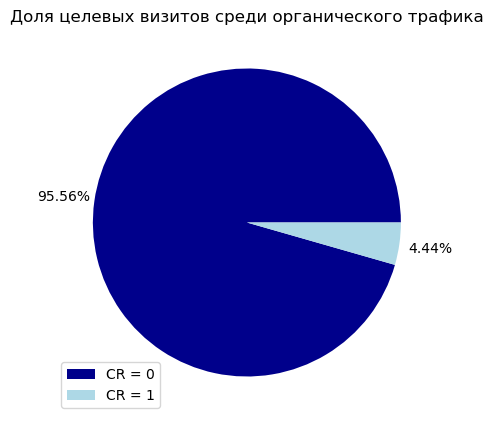

In [85]:
plt.figure(figsize=(5,5))
plt.pie(traffic_table['Органический трафик'], colors = ('darkblue','lightblue'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Доля целевых визитов среди органического трафика')
plt.legend(['CR = 0', 'CR = 1'],loc='lower left')
plt.show()

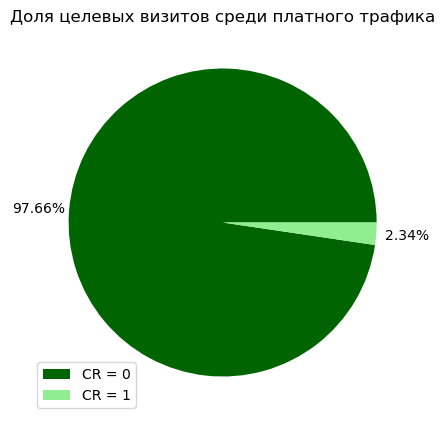

In [86]:
plt.figure(figsize=(5,5))
plt.pie(traffic_table['Платный трафик'], colors = ('darkgreen','lightgreen'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Доля целевых визитов среди платного трафика')
plt.legend(['CR = 0', 'CR = 1'],loc='lower left')
plt.show()

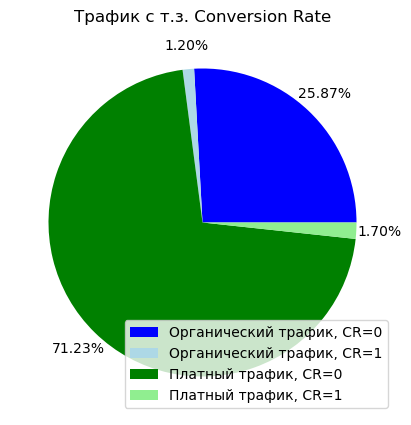

In [87]:
traffic_list_all_values = []
for v1 in (traffic_table.iloc[:, 1:3]).to_dict().values():
    for v2 in v1.values():
        traffic_list_all_values.append(v2)
        
plt.figure(figsize=(5,5))
plt.pie(traffic_list_all_values, colors=['blue','lightblue','green','lightgreen'], autopct='%0.2f%%', pctdistance=1.15)
plt.title('Трафик с т.з. Conversion Rate')
plt.legend(['Органический трафик, CR=0','Органический трафик, CR=1','Платный трафик, CR=0', 'Платный трафик, CR=1'],loc='lower right')
plt.show()

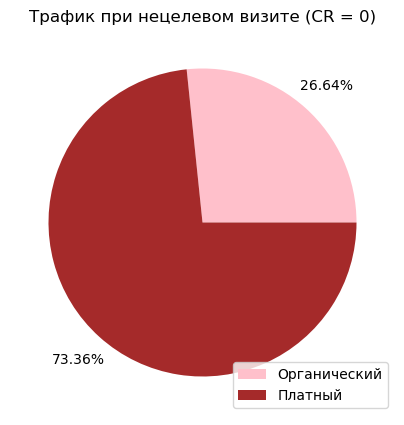

In [88]:
plt.figure(figsize=(5,5))
plt.pie(traffic_table.iloc[0,1:3], colors = ('pink','brown'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Трафик при нецелевом визите (CR = 0)')
plt.legend(['Органический', 'Платный'],loc='lower right')
plt.show()

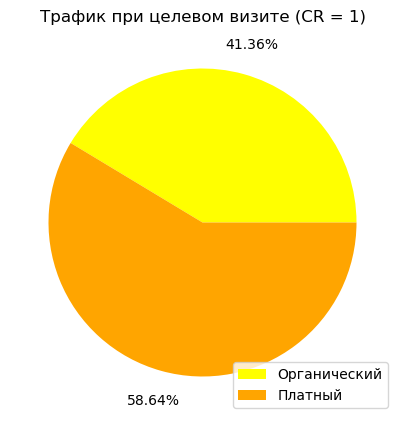

In [89]:
plt.figure(figsize=(5,5))
plt.pie(traffic_table.iloc[1,1:3], colors = ('yellow','orange'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Трафик при целевом визите (CR = 1)')
plt.legend(['Органический', 'Платный'],loc='lower right')
plt.show()

По диаграммам выше можно сделать выводы:

1) Если трафик органический, то статистически целевых действий будет больше почти в 2 раза.

2) В основном преобладает платный трафик (73%).

3) В случаях, если посетитель выполнил целевое действие, то 41% вероятности, что трафик был органический. Если посетитель целевое действие не выполнил, то вероятность, что трафик был органический снижается до 27%. 

#### 7.1.3.2. Категория устройства

In [90]:
device_category_table = pd.DataFrame([['CR = 0', len(df[(df.device_category==1)&(df.target_action==0)]), len(df[(df.device_category==0)&(df.target_action==0)])],
               ['CR = 1', len(df[(df.device_category==1)&(df.target_action==1)]), len(df[(df.device_category==0)&(df.target_action==1)])]], columns=['Целевое действие','Мобильное устройство', 'Десктопное устройство'])

In [91]:
device_category_table

,Целевое действие,Мобильное устройство,Десктопное устройство
0,CR = 0,1346574,335378
1,CR = 1,38801,11513


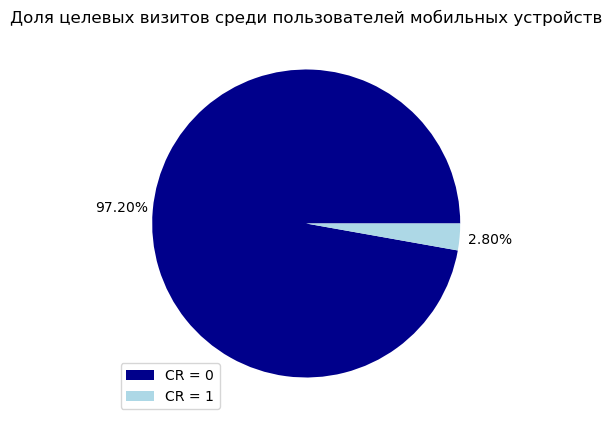

In [92]:
plt.figure(figsize=(5,5))
plt.pie(device_category_table['Мобильное устройство'], colors = ('darkblue','lightblue'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Доля целевых визитов среди пользователей мобильных устройств')
plt.legend(['CR = 0', 'CR = 1'], loc='lower left')
plt.show()

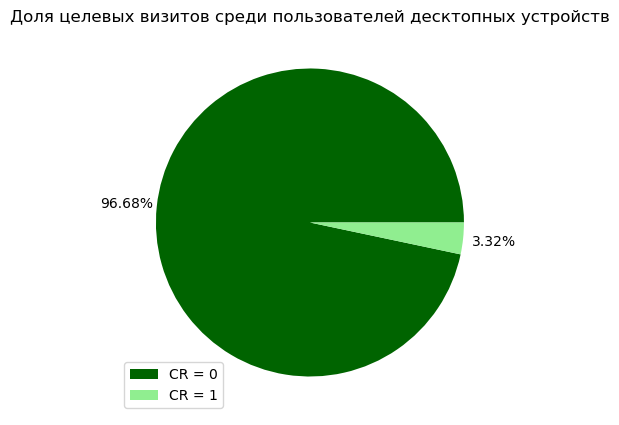

In [93]:
plt.figure(figsize=(5,5))
plt.pie(device_category_table['Десктопное устройство'], colors = ('darkgreen','lightgreen'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Доля целевых визитов среди пользователей десктопных устройств')
plt.legend(['CR = 0', 'CR = 1'], loc='lower left')
plt.show()

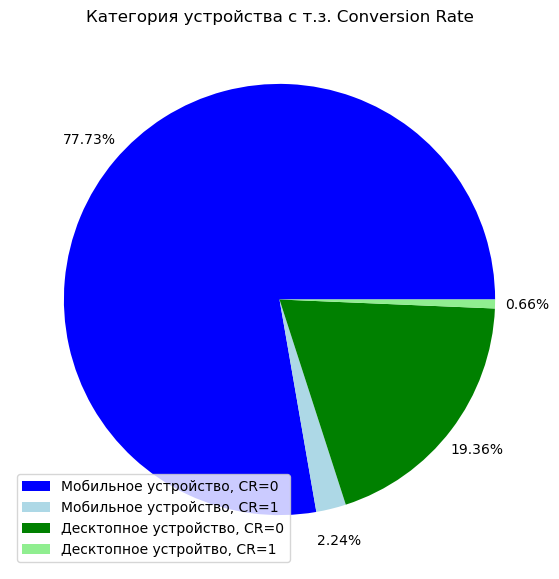

In [94]:
device_category_list_all_values = []
for v1 in (device_category_table.iloc[:, 1:3]).to_dict().values():
    for v2 in v1.values():
        device_category_list_all_values.append(v2)
        
plt.figure(figsize=(7,7))
plt.pie(device_category_list_all_values, colors=['blue','lightblue','green','lightgreen'], autopct='%0.2f%%', pctdistance=1.15)
plt.title('Категория устройства с т.з. Conversion Rate')
plt.legend(['Мобильное устройство, CR=0','Мобильное устройство, CR=1','Десктопное устройство, CR=0', 'Десктопное устройтво, CR=1'],loc='lower left')
plt.show()

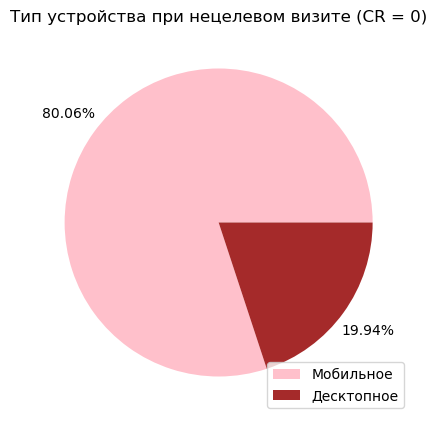

In [95]:
plt.figure(figsize=(5,5))
plt.pie(device_category_table.iloc[0,1:3], colors = ('pink','brown'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Тип устройства при нецелевом визите (CR = 0)')
plt.legend(['Мобильное', 'Десктопное'],loc='lower right')
plt.show()

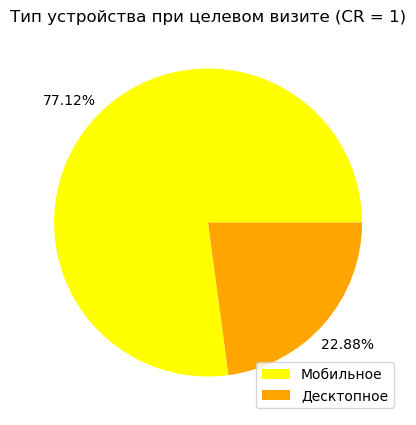

In [96]:
plt.figure(figsize=(5,5))
plt.pie(device_category_table.iloc[1,1:3], colors = ('yellow','orange'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Тип устройства при целевом визите (CR = 1)')
plt.legend(['Мобильное', 'Десктопное'],loc='lower right')
plt.show()

По диаграммам выше можно сделать выводы:

1) Процент конверсии из визита в целевое действие больше у пользователей, зашедших с компьютера (примерно в 1.2 раза).

2) В основном посетители заходят на сайт через мобильные устройства. В абсолютных значениях больше всего целевых действий совершила именно эта категория.

3) В случаях, если посетитель выполнил целевое действие, то 23% вероятности, что устройство, с которого он зашёл - десктопное. Если посетитель целевое действие не выполнил, то 20% вероятность, что пользователь с десктопным устройством.

#### 7.1.3.3. Город присутствия

In [97]:
city_of_presence_table = pd.DataFrame([['CR = 0', len(df[(df.city_of_presence==1)&(df.target_action==0)]), len(df[(df.city_of_presence==0)&(df.target_action==0)])],
               ['CR = 1', len(df[(df.city_of_presence==1)&(df.target_action==1)]), len(df[(df.city_of_presence==0)&(df.target_action==1)])]], columns=['Целевое действие','Город присутствия: да', 'Город присутствия: нет'])

In [98]:
city_of_presence_table

,Целевое действие,Город присутствия: да,Город присутствия: нет
0,CR = 0,1094404,587548
1,CR = 1,33742,16572


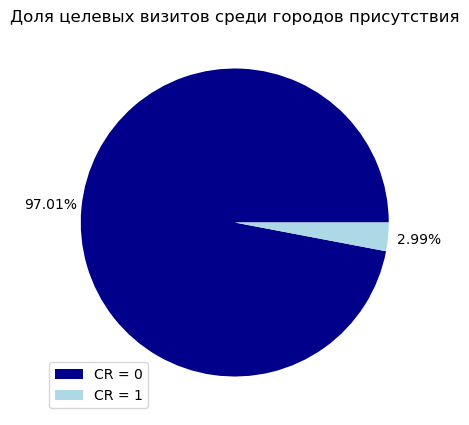

In [99]:
plt.figure(figsize=(5,5))
plt.pie(city_of_presence_table['Город присутствия: да'], colors = ('darkblue','lightblue'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Доля целевых визитов среди городов присутствия')
plt.legend(['CR = 0', 'CR = 1'], loc='lower left')
plt.show()

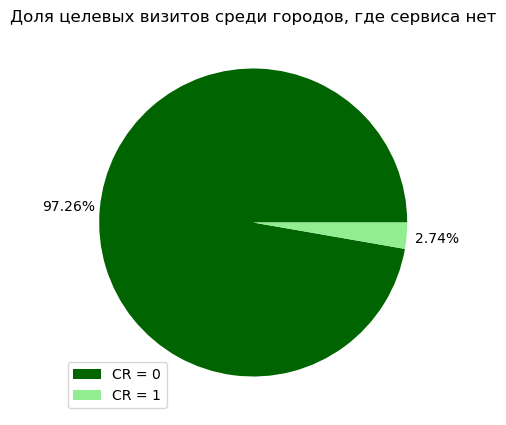

In [100]:
plt.figure(figsize=(5,5))
plt.pie(city_of_presence_table['Город присутствия: нет'], colors = ('darkgreen','lightgreen'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Доля целевых визитов среди городов, где сервиса нет')
plt.legend(['CR = 0', 'CR = 1'], loc='lower left')
plt.show()

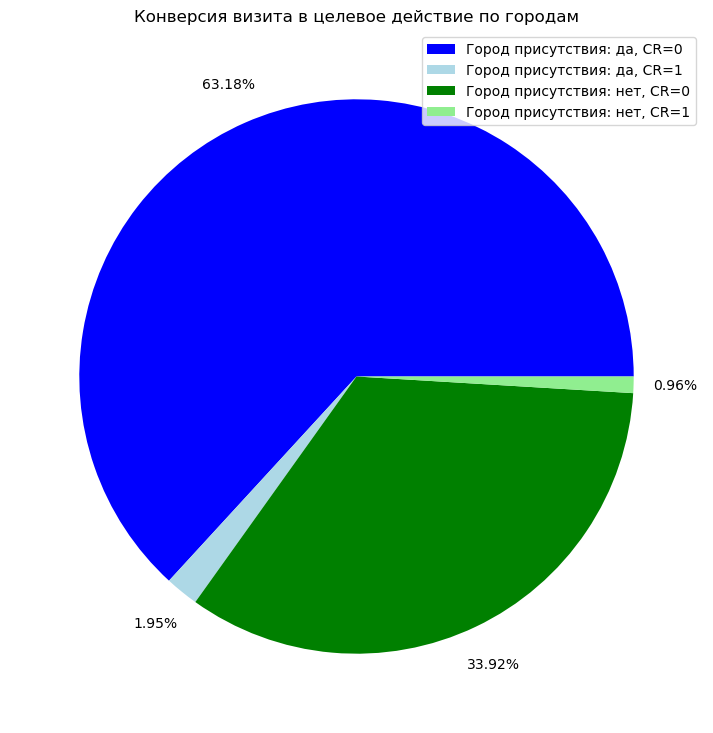

In [101]:
city_of_presence_list_all_values = []
for v1 in (city_of_presence_table.iloc[:, 1:3]).to_dict().values():
    for v2 in v1.values():
        city_of_presence_list_all_values.append(v2)
        
plt.figure(figsize=(9,9))
plt.pie(city_of_presence_list_all_values, colors=['blue','lightblue','green','lightgreen'], autopct='%0.2f%%', pctdistance=1.15)
plt.title('Конверсия визита в целевое действие по городам')
plt.legend(['Город присутствия: да, CR=0','Город присутствия: да, CR=1','Город присутствия: нет, CR=0', 'Город присутствия: нет, CR=1'],loc='upper right')
plt.show()

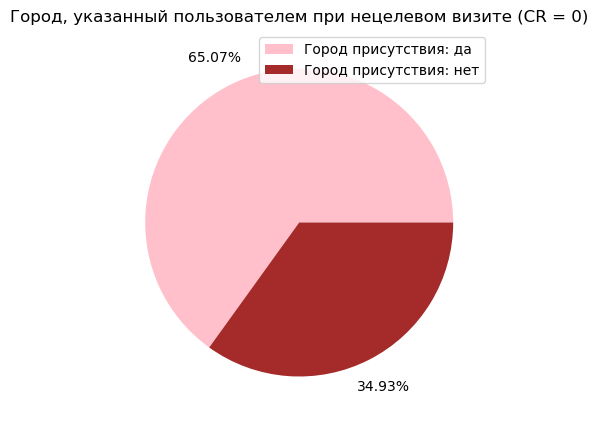

In [102]:
plt.figure(figsize=(5,5))
plt.pie(city_of_presence_table.iloc[0,1:3], colors = ('pink','brown'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Город, указанный пользователем при нецелевом визите (CR = 0)')
plt.legend(['Город присутствия: да', 'Город присутствия: нет'],loc='upper right')
plt.show()

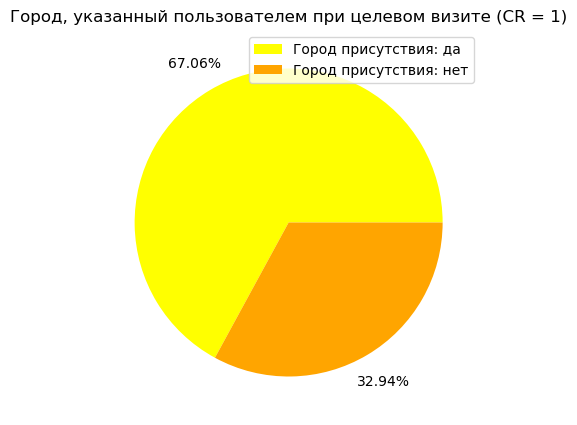

In [103]:
plt.figure(figsize=(5,5))
plt.pie(city_of_presence_table.iloc[1,1:3], colors = ('yellow','orange'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Город, указанный пользователем при целевом визите (CR = 1)')
plt.legend(['Город присутствия: да', 'Город присутствия: нет'],loc='upper right')
plt.show()

По диаграммам выше можно сделать выводы:

1) В случаях указания городов присутствия целевых действий происходило не сильно больше, чем если бы пользователи указали другой город (разница менее чем в 1.1 раза)

2) В основном сайт сервиса посещают пользователи, указывающие в своём местонахождении город присутствия.

3) В случаях, если посетитель выполнил целевое действие, то 35% вероятности, что он НЕ из города присутствия. Если посетитель целевое действие не выполнил, то вероятность, что пользователь НЕ из города присутствия почти такая же: 33%.

## 7.2. Ответы на вопросы продуктовой команды

### 7.2.1. Из каких источников / кампаний / устройств / локаций идёт самый целевой трафик (и с точки зрения объёма трафика, и с точки зрения CR)?

#### 7.2.1.0. Подготовка

In [104]:
df.head()

,session_id,client_id,device_category,browser,country,city,device_brand,rf_subject,city_of_presence,location,traffic,ad_in_social_media,date,manufacturer,model,target_action,month,day_of_week
0,9055434745589932991.1637753792.1637753792,2108382700.163776,1,chrome,Russia,Zlatoust,Huawei,Chelyabinsk Oblast,0,Chelyabinsk Oblast,0,0,2021-11-24,-,-,0,November,Wednesday
1,9069524364331606119.1639735392.1639735392,2111663195.163973,0,yabrowser,Russia,Zlatoust,other,Chelyabinsk Oblast,0,Chelyabinsk Oblast,1,0,2021-12-17,-,-,0,December,Friday
2,9155546735293174720.1638077378.1638077378,2131691839.163808,1,chrome,Russia,Zlatoust,Huawei,Chelyabinsk Oblast,0,Chelyabinsk Oblast,0,0,2021-11-28,skoda,skoda karoq,0,November,Sunday
3,956065502748599172.1638291145.1638291145,222601346.163302,1,samsung internet,Russia,Zlatoust,Samsung,Chelyabinsk Oblast,0,Chelyabinsk Oblast,0,0,2021-11-30,volkswagen,volkswagen polo,0,November,Tuesday
4,967551563856875281.1636830848.1636830848,225275653.163683,1,chrome,Russia,Zlatoust,Samsung,Chelyabinsk Oblast,0,Chelyabinsk Oblast,0,0,2021-11-13,-,-,0,November,Saturday


Напишем функцию, которая строит таблицу, где каждому **уникальному значению выбранного признака (unit)** будет сопоставляться доля его записей в изначальной таблице с CR=1 к общему числу записей, где это уникальное значение (unit) упоминается.

Пример. 
Бренду 'Apple' (unit) будет соответствовать значение: **отношение** числа записей, где этот бренд упоминался **и** где через него было совершено целевое действие, **к числу** записей, где этот бренд просто упоминался.

In [105]:
def unit_fraction_in_group(category):
    units_list = []
    for unit in list(df[category].unique()):
        units_list.append((unit, round((len(df[(df[category]==unit) & (df['target_action']==1)]) / len(df[df[category]==unit]))*100, 2)))

    return pd.DataFrame(units_list, columns = [category, 'unit_fraction_in_group'])

Напишем функцию, которая строит таблицу, где каждому **уникальному значению выбранного признака (unit)** будет сопоставляться доля его записей в изначальной таблице с CR=1 к общему числу записей.

Пример. 
Бренду 'Apple' (unit) будет соответствовать значение: **отношение** числа записей, где этот бренд упоминался **и** где через него было совершено целевое действие, **к числу** всех записей.

Таблица будет объединяться с той, что последняя выше.

In [106]:
def unit_fraction_in_total(category, data):
    part_df = pd.DataFrame(pd.Series(df[df.target_action==1][category].value_counts().apply(lambda x: x/len(df)*100)))
    part_df.columns = ['unit_fraction_in_total']
    part_df.index.rename(category, inplace=True)

    return pd.merge(left = data, right = part_df, on = category, how = 'left')

Напишем функцию, которая строит таблицу, где каждому **уникальному значению выбранного признака (unit)** будет сопоставляться доля записей, где он упоминается, к общему числу записей.

Пример. 
Бренду 'Apple' (unit) будет соответствовать значение: **отношение** числа записей, где этот бренд упоминался, **к числу** всех записей.

Таблица будет объединяться с той, что последняя выше.

In [107]:
def percent_freq(category, data):
    part_df = pd.DataFrame(pd.Series(df[category].value_counts().apply(lambda x: x/len(df)*100)))
    part_df.columns = ['percent_freq']
    part_df.index.rename(category, inplace=True)

    return pd.merge(left = data, right = part_df, on = category, how = 'left')

Напишем функцию, которая строит таблицу, где каждому **уникальному значению выбранного признака (unit)** будет сопоставляться число записей, сколько раз он упоминается.

Таблица будет объединяться с той, что последняя выше.

In [108]:
def absolute_freq(category, data):
    part_df= pd.DataFrame(pd.Series(df[category].value_counts()))
    part_df.columns=['absolute_freq']
    part_df.index.rename(category, inplace=True)

    return pd.merge(left = data, right = part_df, on = category, how = 'left')

Исследуем интересующие нас признаки с помощью функций выше.

In [109]:
features_list = ['device_brand', 'browser', 'date', 'day_of_week', 'month', 'location']

In [110]:
features_df_list = []
for category in features_list:
    feature_df = absolute_freq(category, percent_freq(category, unit_fraction_in_total(category, unit_fraction_in_group(category))))
    feature_df['unit_fraction_in_total'] = feature_df['unit_fraction_in_total'].apply(lambda x: x if x>0 else 0)
    feature_df['unit_fraction_in_total'] = feature_df['unit_fraction_in_total'].apply(lambda x: round(x,2))
    feature_df['percent_freq (rounded)'] = feature_df['percent_freq'].apply(lambda x: round(x,1))
    features_df_list.append(feature_df)

Дадим имена новым таблицам.

In [111]:
device_brand_df, browser_df, date_df, day_of_week_df, month_df, location_df = features_df_list[0], features_df_list[1], features_df_list[2], features_df_list[3], features_df_list[4], features_df_list[5]

#### 7.2.1.1. device_brand

##### 7.2.1.1.1. расчёты с точки зрения CR

Найдём, с каких популярных брендов (более 0.1% владельцев по выборке) самый большой и самый маленький процент конверсии.

In [112]:
device_brand_df[device_brand_df['percent_freq (rounded)']>0.1].sort_values(by=['unit_fraction_in_group'],ascending=False)

,device_brand,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
1,other,3.32,0.66,20.042880,347196,20.0
2,Samsung,3.23,0.58,17.990366,311641,18.0
15,OPPO,3.10,0.02,0.737473,12775,0.7
12,Vivo,2.92,0.02,0.636507,11026,0.6
3,Apple,2.87,0.84,29.067880,503533,29.1
8,(not set),2.77,0.03,0.946275,16392,0.9
0,Huawei,2.60,0.26,10.034718,173828,10.0
21,Google,2.53,0.01,0.258159,4472,0.3
22,ZTE,2.49,0.01,0.345617,5987,0.3
20,Sony,2.46,0.01,0.352486,6106,0.4


Заметно, что процент посетителей популярных брендов с CR=1 относительно всех посетителей с CR=1 составляет приблизительно 2-4% по каждой компании.

Среди посетителей, обладающих брендом высокого спроса (более 0.1% владельцев по выборке) топ-5 наибольшая конверсия в целевое действие наблюдается у посетителей с устройствами: 

**1) Sumsung (3.23%)**,

**2) OPPO (3.10%)**,

**3) Vivo (2.92%)**,

**4) Apple (2.87%)**,

**5) Huawei (2.60%)**.

Среди посетителей, обладающих брендом высокого спроса (более 0.1% владельцев по выборке) топ-3 наименьшая конверсия в целевое действие наблюдается у посетителей с устройствами: 

**1) OnePlus (1.68%)**,

**2) Asus (1.92%)**,

**3) Meizu (2.10%)**.

##### 7.2.1.1.2. расчёты с точки зрения всего объёма трафика

Найдём, вероятность, что клиент совершит целевое действие, и при будет обладать конкретным брендом (учитывается весь трафик).

In [113]:
device_brand_df.sort_values(by=['percent_freq (rounded)', 'unit_fraction_in_total'],ascending=False).head(10)

,device_brand,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
3,Apple,2.87,0.84,29.067880,503533,29.1
1,other,3.32,0.66,20.042880,347196,20.0
2,Samsung,3.23,0.58,17.990366,311641,18.0
4,Xiaomi,2.45,0.38,15.543283,269251,15.5
0,Huawei,2.60,0.26,10.034718,173828,10.0
6,Realme,2.35,0.02,1.034830,17926,1.0
8,(not set),2.77,0.03,0.946275,16392,0.9
15,OPPO,3.10,0.02,0.737473,12775,0.7
12,Vivo,2.92,0.02,0.636507,11026,0.6
10,OnePlus,1.68,0.01,0.538139,9322,0.5


Топ-5:

1) Apple (CR 0.84% среди всех записей, 503 тыс. клиентов пользуются),

2) Sumsung (CR 0.58% среди всех записей, 347 тыс. клиентов пользуются),

3) Xiaomi (CR 0.38% среди всех записей, 311 тыс. клиентов пользуются),

4) Huawei (CR 0.26% среди всех записей, 269 тыс. клиентов пользуются),

5) Realme (CR 0.02% среди всех записей, 173 тыс. клиентов пользуются).

#### 7.2.1.2. browser

##### 7.2.1.2.1. расчёты с точки зрения CR

Найдём, с каких популярных браузеров (более 0.1% пользователей по выборке) самый большой процент конверсии.

In [114]:
browser_df[browser_df['percent_freq (rounded)']>=0.1].sort_values(by=['unit_fraction_in_group'],ascending=False)

,browser,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
8,mozilla_firefox,3.59,0.03,0.928841,16090,0.9
7,edge,3.46,0.03,0.877232,15196,0.9
1,yabrowser,3.30,0.24,7.144688,123765,7.1
4,android webview,3.00,0.09,2.997172,51919,3.0
3,safari,2.89,0.84,29.017310,502657,29.0
0,chrome,2.86,1.57,54.932268,951573,54.9
2,samsung internet,2.84,0.07,2.555785,44273,2.6
5,opera,2.23,0.03,1.449951,25117,1.4


Топ-4 популярных браузеров с самым высоким полказателем конверсии:

**1) Mozilla Firefox (3.59%)**,

**2) Microsoft Edge (3.46%)**,

**3) Yandex Browser (3.30%)**,

**4) Android Web (3%)**.

Топ-4 популярных браузеров с самым низким полказателем конверсии:

**1) Opera (2.23%)**,

**2) Sumsung Internet (2.84%)**,

**3) Chrome (2.86%)**,

**4) Safari (2.89%)**.

##### 7.2.1.2.2. расчёты с точки зрения всего объёма трафика

Найдём, вероятность, что клиент совершит целевое действие, и при будет пользоваться конкретным браузером (учитывается весь трафик).

In [115]:
browser_df.sort_values(by=['percent_freq (rounded)', 'unit_fraction_in_total'],ascending=False).head(10)

,browser,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
0,chrome,2.86,1.57,54.932268,951573,54.9
3,safari,2.89,0.84,29.017310,502657,29.0
1,yabrowser,3.30,0.24,7.144688,123765,7.1
4,android webview,3.00,0.09,2.997172,51919,3.0
2,samsung internet,2.84,0.07,2.555785,44273,2.6
5,opera,2.23,0.03,1.449951,25117,1.4
7,edge,3.46,0.03,0.877232,15196,0.9
8,mozilla_firefox,3.59,0.03,0.928841,16090,0.9
6,mrchrome,1.39,0.00,0.004156,72,0.0
9,helloworld,0.00,0.00,0.000346,6,0.0


Топ-5:

1) Chrome (CR 1.57% среди всех записей, а всего пользуются 951 тыс. клиентов),

2) Safari (CR 0.84% среди всех записей, а всего пользуются 502 тыс. клиентов),

3) Yandex Browser (CR 0.24% среди всех записей, а всего пользуются 123 тыс. клиентов),

4) Android Web (CR 3% среди всех записей, а всего пользуются 51 тыс. клиентов),

5) Samsung Interner (CR 0.07% среди всех записей, а всего пользуются 44 тыс. клиентов).

#### 7.2.1.3. date

##### 7.2.1.3.1. расчёты с точки зрения CR

In [116]:
date_df[date_df['percent_freq (rounded)']>=0.1].sort_values(by=['unit_fraction_in_group'],ascending=False)

,date,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
210,2021-06-03,7.84,0.01,0.166429,2883,0.2
176,2021-05-26,7.53,0.04,0.576124,9980,0.6
153,2021-05-27,7.36,0.03,0.455011,7882,0.5
223,2021-06-02,7.16,0.01,0.186230,3226,0.2
221,2021-06-07,7.00,0.01,0.164986,2858,0.2
...,...,...,...,...,...,...
54,2021-12-05,1.63,0.01,0.691984,11987,0.7
142,2021-09-25,1.52,0.01,0.537850,9317,0.5
33,2021-12-26,1.47,0.01,0.665718,11532,0.7
12,2021-12-30,1.38,0.01,0.709937,12298,0.7


##### 7.2.1.3.2. расчёты с точки зрения всего объёма трафика

In [117]:
date_df.sort_values(by=['percent_freq (rounded)', 'unit_fraction_in_total'],ascending=False).head(10)

,date,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
63,2021-05-24,6.46,0.15,2.264664,39230,2.3
123,2021-12-21,2.54,0.04,1.723985,29864,1.7
58,2021-05-25,6.84,0.08,1.106066,19160,1.1
167,2021-06-29,1.97,0.02,0.974850,16887,1.0
19,2021-06-28,2.10,0.02,0.858990,14880,0.9
118,2021-09-14,2.64,0.02,0.899573,15583,0.9
18,2021-10-29,1.70,0.01,0.870825,15085,0.9
22,2021-11-17,2.29,0.02,0.801147,13878,0.8
25,2021-11-16,2.32,0.02,0.817542,14162,0.8
28,2021-12-22,2.25,0.02,0.760218,13169,0.8


Хоть по датам и можно составить рейтинг, когда больше, а когда меньше происходит целевых действий, такое распределение всё-таки будет носить скорее **случайный характер**. Нет привязки к конкретным датам: первым числам месяца или последним, праздничным дням или обычным.

#### 7.2.1.4. day_of_week

##### 7.2.1.4.1. расчёты с точки зрения CR

In [118]:
day_of_week_df.sort_values(by=['unit_fraction_in_group'],ascending=False)

,day_of_week,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
5,Monday,3.36,0.55,16.266382,281777,16.3
0,Wednesday,3.02,0.42,13.909007,240941,13.9
3,Tuesday,3.02,0.50,16.567779,286998,16.6
6,Thursday,2.87,0.42,14.561274,252240,14.6
1,Friday,2.64,0.38,14.348258,248550,14.3
4,Saturday,2.64,0.32,12.189756,211159,12.2
2,Sunday,2.63,0.32,12.157544,210601,12.2


##### 7.2.1.4.2. расчёты с точки зрения всего объёма трафика

In [119]:
day_of_week_df.sort_values(by=['unit_fraction_in_total'],ascending=False)

,day_of_week,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
5,Monday,3.36,0.55,16.266382,281777,16.3
3,Tuesday,3.02,0.50,16.567779,286998,16.6
0,Wednesday,3.02,0.42,13.909007,240941,13.9
6,Thursday,2.87,0.42,14.561274,252240,14.6
1,Friday,2.64,0.38,14.348258,248550,14.3
2,Sunday,2.63,0.32,12.157544,210601,12.2
4,Saturday,2.64,0.32,12.189756,211159,12.2


**В первой половине недели конверсия из визита в целевое действие выше**. Да и общий трафик больше. Похоже, с началом рабочих дней люди больше задумываются о собственном авто, нежели о поездках в общественном транспорте :-)

#### 7.2.1.5. month

##### 7.2.1.5.1.  расчёты с точки зрения CR

In [120]:
month_df.sort_values(by=['unit_fraction_in_group'],ascending=False)

,month,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
7,May,6.15,0.37,6.037814,104591,6.0
5,June,4.11,0.38,9.272363,160622,9.3
6,August,3.55,0.32,8.947991,155003,8.9
3,July,2.80,0.28,10.085518,174708,10.1
2,October,2.70,0.41,15.208923,263459,15.2
4,September,2.48,0.35,14.074224,243803,14.1
0,November,2.44,0.37,15.230629,263835,15.2
1,December,1.99,0.42,21.142538,366245,21.1


##### 7.2.1.5.2. расчёты с точки зрения всего объёма трафика

In [121]:
month_df.sort_values(by=['unit_fraction_in_total'],ascending=False)

,month,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
1,December,1.99,0.42,21.142538,366245,21.1
2,October,2.70,0.41,15.208923,263459,15.2
5,June,4.11,0.38,9.272363,160622,9.3
0,November,2.44,0.37,15.230629,263835,15.2
7,May,6.15,0.37,6.037814,104591,6.0
4,September,2.48,0.35,14.074224,243803,14.1
6,August,3.55,0.32,8.947991,155003,8.9
3,July,2.80,0.28,10.085518,174708,10.1


In [122]:
month_df.sort_values(by=['absolute_freq'],ascending=False)

,month,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
1,December,1.99,0.42,21.142538,366245,21.1
0,November,2.44,0.37,15.230629,263835,15.2
2,October,2.70,0.41,15.208923,263459,15.2
4,September,2.48,0.35,14.074224,243803,14.1
3,July,2.80,0.28,10.085518,174708,10.1
5,June,4.11,0.38,9.272363,160622,9.3
6,August,3.55,0.32,8.947991,155003,8.9
7,May,6.15,0.37,6.037814,104591,6.0


Общий трафик с течением времени увеличивается. Отсюда и бóльшие вероятности (по абсолютным значениям), что клиент совершит целевое действие в конкретный месяц.

Заметно, что самый целевой трафик приходится на **тёплые месяцы** в году. Возможно, это связано с сезоном отпусков. Но при этом стоит отметить, что бизнес существует только 8 месяцев, **наблюдений пока недостаточно**, чтобы делать выводы.

#### 7.2.1.6. location

##### 7.2.1.6.1.  расчёты с точки зрения CR

Найдём, с каких локаций (при условии, что более 10 000 пользователей по выборке отметили её как своё местоположение) самый большой процент конверсии.

In [123]:
location_df[location_df['absolute_freq']>10000].sort_values(by=['unit_fraction_in_group'],ascending=False)

,location,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
131,Republic of Tatarstan,4.03,0.07,1.779577,30827,1.8
4,Krasnodar Krai,3.54,0.09,2.458572,42589,2.5
148,Chechen Republic,3.34,0.02,0.693542,12014,0.7
1,Moscow,3.15,1.36,43.349462,750928,43.3
146,Republic of Bashkortostan,3.11,0.04,1.293219,22402,1.3
136,Samara Oblast,3.08,0.04,1.455666,25216,1.5
6,Moscow Oblast,3.04,0.17,5.704436,98816,5.7
135,Rostov Oblast,2.98,0.02,0.834110,14449,0.8
133,Tula Oblast,2.97,0.03,0.885430,15338,0.9
143,Nizhny Novgorod Oblast,2.67,0.03,1.268685,21977,1.3


Топ-5 самых отмечаемых локаций с самым высоким полказателем конверсии:

**1) Татарстан (4.03%)**,

**2) Краснодарский Край (3.54%)**,

**3) Чеченская Республика (3.34%)**,

**4) Москва (3.15%)**,

**5) Башкортостан (3.11%)**.

Топ-3 самых отмечаемых локаций с самым низким полказателем конверсии:

**1) Приморский Край (2.15%)**,

**2) Воронежская область (2.24%)**,

**3) Красноярский Край (2.45%)**.

##### 7.2.1.6.2. расчёты с точки зрения всего объёма трафика

Найдём, вероятность, что клиент совершит целевое действие, находясь при этом в *конкретном регионе* (учитывается весь трафик).

In [124]:
location_df.sort_values(by=['percent_freq (rounded)', 'unit_fraction_in_total'],ascending=False).head(10)

,location,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
1,Moscow,3.15,1.36,43.349462,750928,43.3
3,Saint Petersburg,2.55,0.41,16.071550,278402,16.1
6,Moscow Oblast,3.04,0.17,5.704436,98816,5.7
7,other,2.17,0.10,4.660023,80724,4.7
4,Krasnodar Krai,3.54,0.09,2.458572,42589,2.5
134,Sverdlovsk Oblast,2.63,0.05,2.083802,36097,2.1
131,Republic of Tatarstan,4.03,0.07,1.779577,30827,1.8
136,Samara Oblast,3.08,0.04,1.455666,25216,1.5
146,Republic of Bashkortostan,3.11,0.04,1.293219,22402,1.3
143,Nizhny Novgorod Oblast,2.67,0.03,1.268685,21977,1.3


Топ-6:

1) Москва (CR 1.36% среди всех записей, 750 тыс. посетителей указали),

2) Санкт-Петербург (CR 0.41% среди всех записей, 278 тыс. посетителей указали),

3) Московская область (CR 0.17% среди всех записей, 98 тыс. посетителей указали),

4) Краснодарский Край (CR 0.09% среди всех записей, 42 тыс. посетителей указали),

5) Свердловская область (CR 0.05% среди всех записей, 36 тыс. посетителей указали),

6) Татарстан (CR 0.07% среди всех записей, 30 тыс. посетителей указали).

Вполне ожидаемо, что больше интересоваться сервисом будут в городах присутствия. Также интерес проявляют жители крупных богатых регионов России, хотя численно их сильно меньше.

### 7.2.2. Какие авто пользуются наибольшим спросом? У каких авто самый лучший показатель CR (Conversion Rate) в целевые события?

#### 7.2.2.0. Подготовим данные для ответа.

In [125]:
car_names = ['manufacturer', 'model']

In [126]:
car_names_df_list = []
for name in car_names:
    car_name_df = absolute_freq(name, percent_freq(name, unit_fraction_in_total(name, unit_fraction_in_group(name))))
    car_name_df['unit_fraction_in_total'] = car_name_df['unit_fraction_in_total'].apply(lambda x: x if x>0 else 0)
    car_name_df['unit_fraction_in_total'] = car_name_df['unit_fraction_in_total'].apply(lambda x: round(x,2))
    car_name_df['percent_freq (rounded)'] = car_name_df['percent_freq'].apply(lambda x: round(x,1))
    car_names_df_list.append(car_name_df)

Дадим имена новым таблицам.

In [127]:
manufacturer_df, model_df = car_names_df_list[0], car_names_df_list[1]

#### 7.2.2.1. manufacturer

##### 7.2.2.1.1. У каких производителей самый лучший коэффициент конверсии?

Найдём, по каким известным производителям автомобилей (более 0.1% по выборке) самый большой процент конверсии из визита в целевое действие.

In [128]:
manufacturer_df[manufacturer_df['percent_freq (rounded)']>=0.1].sort_values(by=['unit_fraction_in_group'],ascending=False)

,manufacturer,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
2,volkswagen,7.51,0.22,2.975640,51546,3.0
4,toyota,6.56,0.06,0.918854,15917,0.9
11,kia,6.15,0.04,0.638355,11058,0.6
5,lada-vaz,6.09,0.12,1.929438,33423,1.9
17,hyundai,6.09,0.00,0.073892,1280,0.1
1,skoda,5.45,0.22,4.059827,70327,4.1
15,haval,5.27,0.01,0.159791,2768,0.2
8,volvo,4.24,0.02,0.404730,7011,0.4
6,renault,4.04,0.04,0.877983,15209,0.9
18,peugeot,3.24,0.00,0.124634,2159,0.1


Топ-5 известных производителей с самым высоким полказателем конверсии:

**1) volkswagen (7.51%)**,

**2) toyota (6.56%)**,

**3) kia (6.15%)**,

**4) lada (6.09%)**,

**5) hyundai (6.09%)**.

Топ-5 известных производителей с самым низким полказателем конверсии:

**1) land-rover (1.53%)**,

**2) porsche (1.62%)**,

**3) audi (1.74%)**,

**4) lexus (1.88%)**,

**5) mini (2.20%)**.

##### 7.2.2.1.2. Какие производители автомобилей пользуются самым наибольшим спросом?

In [129]:
manufacturer_df.sort_values(by=['percent_freq (rounded)', 'unit_fraction_in_total'],ascending=False).head(10)

,manufacturer,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
0,-,2.46,2.04,82.836585,1434950,82.8
1,skoda,5.45,0.22,4.059827,70327,4.1
2,volkswagen,7.51,0.22,2.975640,51546,3.0
7,mercedes-benz,3.02,0.06,2.111512,36577,2.1
5,lada-vaz,6.09,0.12,1.929438,33423,1.9
3,nissan,2.86,0.03,1.206224,20895,1.2
4,toyota,6.56,0.06,0.918854,15917,0.9
6,renault,4.04,0.04,0.877983,15209,0.9
11,kia,6.15,0.04,0.638355,11058,0.6
14,bmw,2.91,0.02,0.576355,9984,0.6


Топ-5:

1) skoda (CR 0.22% среди всех записей, 70 тыс. клиентов искали),

2) volkswagen (CR 0.22% среди всех записей, 51 тыс. клиентов искали),

3) merzedes (CR 0.06% среди всех записей, 36 тыс. клиентов искали),

4) lada (CR 0.12% среди всех записей, 33 тыс. клиентов искали),

5) nissan (CR 0.03% среди всех записей, 20 тыс. клиентов искали).

#### 7.2.2.2. model

##### 7.2.2.2.1. У каких моделей машин самый лучший коэффициент конверсии?

Найдём, по каким известным моделям автомобилей (более 0.1% по выборке) самый большой процент конверсии из визита в целевое действие.

In [130]:
model_df[model_df['percent_freq (rounded)']>0.1].sort_values(by=['unit_fraction_in_group'],ascending=False)

,model,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
4,toyota camry,8.49,0.04,0.416160,7209,0.4
2,volkswagen polo,8.34,0.19,2.281116,39515,2.3
30,kia rio,7.61,0.02,0.248114,4298,0.2
17,kia seltos,6.19,0.01,0.174396,3021,0.2
8,skoda rapid,6.12,0.16,2.637874,45695,2.6
5,lada-vaz vesta,6.09,0.12,1.929438,33423,1.9
6,skoda octavia,6.04,0.02,0.327894,5680,0.3
9,renault logan,5.58,0.02,0.409695,7097,0.4
29,haval jolion,5.27,0.01,0.159791,2768,0.2
7,volkswagen tiguan,5.08,0.02,0.461592,7996,0.5


Топ-7 известных модели с самым высоким полказателем конверсии:

**1) toyota camry (8.49%)**,

**2) volkswagen polo (8.34%)**,

**3) kia rio (7.61%)**,

**4) kia seltos (6.19%)**,

**5) skoda rapid (6.12%)**,

**6) lada vesta (6.09%)**,

**7) skoda octavia (6.04%)**.

Топ-6 известных модели с самым низким полказателем конверсии:

**1) lexus rx (0.95%)**,

**2) porsche cayenne (1.96%)**,

**3) mercedes glb (2.12%)**,

**4) renault duster (2.57%)**,

**5) nissan qashqai	 (2.75%)**,

**6) mercedes gle (2.77%)**.

##### 7.2.2.2.2. Какие модели автомобилей пользуются самым наибольшим спросом?

In [131]:
model_df.sort_values(by=['percent_freq (rounded)', 'unit_fraction_in_total'],ascending=False).head(10)

,model,unit_fraction_in_group,unit_fraction_in_total,percent_freq,absolute_freq,percent_freq (rounded)
0,-,2.46,2.04,82.836585,1434950,82.8
8,skoda rapid,6.12,0.16,2.637874,45695,2.6
2,volkswagen polo,8.34,0.19,2.281116,39515,2.3
5,lada-vaz vesta,6.09,0.12,1.929438,33423,1.9
1,skoda karoq,3.80,0.04,0.953664,16520,1.0
22,mercedes-benz e-klasse,3.29,0.03,0.898130,15558,0.9
3,nissan qashqai,2.75,0.02,0.739782,12815,0.7
7,volkswagen tiguan,5.08,0.02,0.461592,7996,0.5
19,renault duster,2.57,0.01,0.465864,8070,0.5
21,nissan x-trail,3.03,0.01,0.466441,8080,0.5


Топ-5:

1) skoda rapid (CR 0.16% среди всех записей, 45 тыс. клиентов искали),

2) volkswagen polo (CR 0.19% среди всех записей, 39 тыс. клиентов искали),

3) lada vesta (CR 0.12% среди всех записей, 33 тыс. клиентов искали),

4) skoda karoq (CR 0.04% среди всех записей, 16 тыс. клиентов искали),

5) mercedes e-klasse (CR 0.03% среди всех записей, 15 тыс. клиентов искали).

### 7.2.3. Стоит ли увеличивать своё присутствие в соцсетях и давать там больше рекламы?

Для ответа на этот вопрос лучше его предстваить в виде проверки гипотезы.
Трафик пользователей, перешедших с рекламы в соцсетях не отличается от нашедших сайт другим способом с точки зрения конверсии в целевое действие. Н0: не отличается, Н1: отличается (в большую или меньшую сторону).

#### 7.2.3.1. Проверка гипотезы, статистические вычисления

In [132]:
ad_in_social_media_df = generate_df_for_test(df, 'ad_in_social_media')

In [133]:
ad_in_social_media_df.cr_true = ad_in_social_media_df.cr_true.apply(lambda x: x if x>0 else 0)
ad_in_social_media_df.cr_false = ad_in_social_media_df.cr_false.apply(lambda x: x if x>0 else 0)

In [134]:
ad_in_social_media_df

,date,cr_true,cr_false
0,2021-05-19,0.000000,7.112376
1,2021-05-21,0.000000,0.000000
2,2021-05-22,0.000000,1.445466
3,2021-05-23,0.000000,4.147881
4,2021-05-24,0.000000,6.464935
...,...,...,...
221,2021-12-27,2.751629,1.994885
222,2021-12-28,2.012384,2.032249
223,2021-12-29,2.827763,1.701503
224,2021-12-30,4.530744,1.301193


In [135]:
ad_norm_answer, ad_norm_pvalue = check_normality(ad_in_social_media_df)
if ad_norm_answer == False:
    print('Для проверки используется критерий Манна-Уитни')
    do_mann_whitney_test(ad_in_social_media_df)
else:
    ad_levene_answer, ad_levene_pvalue = test_levene(ad_in_social_media_df)
    if ad_levene_answer == True:
        print('Для проверки используется критерий Стьюдента')
        do_ttest_equal_var_true(ad_in_social_media_df)
    else:
        pass
    if ad_levene_answer == False:
        print('Для проверки используется критерий Уэлча')
        do_ttest_equal_var_false(ad_in_social_media_df)

Данные в признаке распределены нормально: False, статистическая значимость: 7.009965505953527e-27%, примерно 0.0% 
Для проверки используется критерий Манна-Уитни
Выборки статистически НЕ отличаются: False, статистическая значимость: 1.3525735159774791e-35%, примерно 0.0% 
Посетители с интересующим значением признака ("1") с МЕНЬШЕЙ вероятностью совершат целевое действие.


#### 7.2.3.2. Визуализация

In [136]:
ad_in_social_media_table = pd.DataFrame([['CR = 0', len(df[(df.ad_in_social_media==1)&(df.target_action==0)]), len(df[(df.ad_in_social_media==0)&(df.target_action==0)])],
               ['CR = 1', len(df[(df.ad_in_social_media==1)&(df.target_action==1)]), len(df[(df.ad_in_social_media==0)&(df.target_action==1)])]], columns=['Целевое действие', 'Трафик с рекламы в соц. сетях', 'Трафик с рекламы в другом месте'])

In [137]:
ad_in_social_media_table

,Целевое действие,Трафик с рекламы в соц. сетях,Трафик с рекламы в другом месте
0,CR = 0,252259,1429693
1,CR = 1,4021,46293


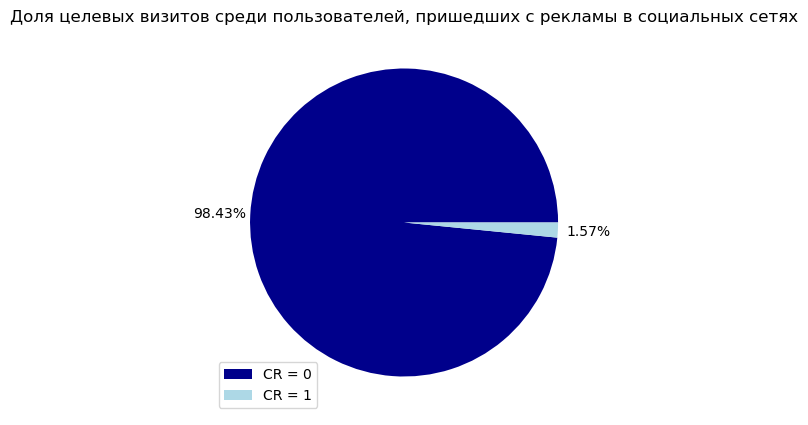

In [138]:
plt.figure(figsize=(5,5))
plt.pie(ad_in_social_media_table['Трафик с рекламы в соц. сетях'], colors = ('darkblue','lightblue'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Доля целевых визитов среди пользователей, пришедших с рекламы в социальных сетях')
plt.legend(['CR = 0', 'CR = 1'], loc='lower left')
plt.show()

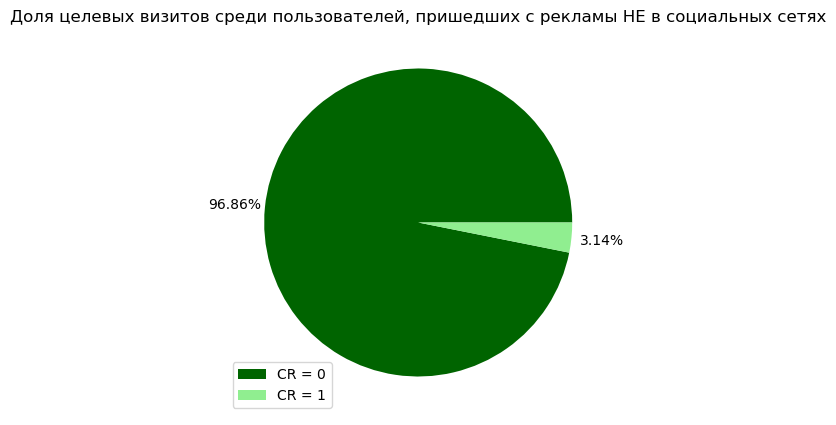

In [139]:
plt.figure(figsize=(5,5))
plt.pie(ad_in_social_media_table['Трафик с рекламы в другом месте'], colors = ('darkgreen','lightgreen'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Доля целевых визитов среди пользователей, пришедших с рекламы НЕ в социальных сетях')
plt.legend(['CR = 0', 'CR = 1'],loc='lower left')
plt.show()

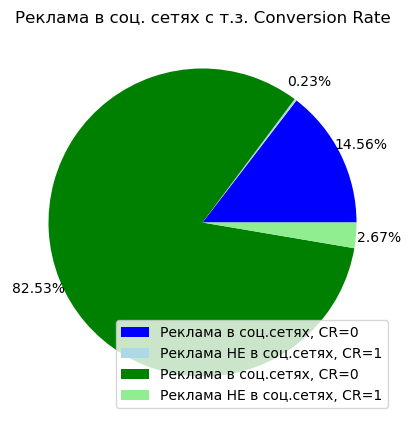

In [140]:
ad_in_social_media_list_all_values = []
for v1 in (ad_in_social_media_table.iloc[:, 1:3]).to_dict().values():
    for v2 in v1.values():
        ad_in_social_media_list_all_values.append(v2)
        
plt.figure(figsize=(5,5))
plt.pie(ad_in_social_media_list_all_values, colors=['blue','lightblue','green','lightgreen'], autopct='%0.2f%%', pctdistance=1.15)
plt.title('Реклама в соц. сетях с т.з. Conversion Rate')
plt.legend(['Реклама в соц.сетях, CR=0','Реклама НЕ в соц.сетях, CR=1','Реклама в соц.сетях, CR=0', 'Реклама НЕ в соц.сетях, CR=1'],loc='lower right')
plt.show()

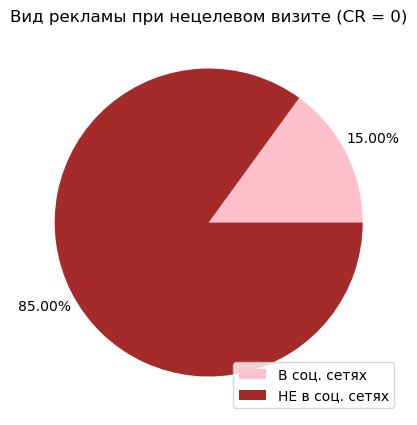

In [141]:
plt.figure(figsize=(5,5))
plt.pie(ad_in_social_media_table.iloc[0,1:3], colors = ('pink','brown'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Вид рекламы при нецелевом визите (CR = 0)')
plt.legend(['В соц. сетях', 'НЕ в соц. сетях'],loc='lower right')
plt.show()

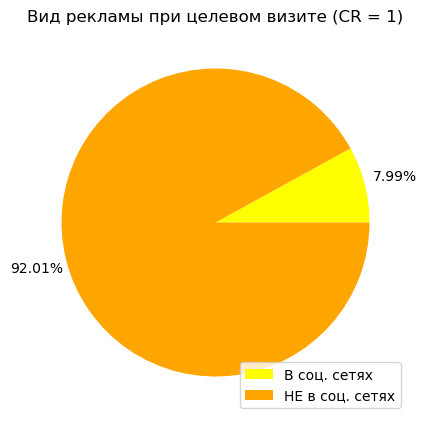

In [142]:
plt.figure(figsize=(5,5))
plt.pie(ad_in_social_media_table.iloc[1,1:3], colors = ('yellow','orange'), autopct='%0.2f%%', pctdistance=1.2)
plt.title('Вид рекламы при целевом визите (CR = 1)')
plt.legend(['В соц. сетях', 'НЕ в соц. сетях'],loc='lower right')
plt.show()

1) Посетители с рекламы в социальных сетях меньше склонны совершать целевое действие как в абсолютных, таки в относительных значениях. Проверка статистическим критерием это тоже подтверждает.

2) В случаях, если посетитель выполнил целевое действие, то 8% вероятности, что он пришёл из соцсетей. Если посетитель целевое действие не выполнил, то вероятность, что посетитель пришёл из соцсетей больше в 2 раза: 15%.

# 8. Выводы

1. Посетители, которые нашли сайт сами (с органическим трафиком) с большей вероятностью совершат целевое действие.

2. Вид устройства статистически не влияет на вероятность свершения посетителем целевого действия.

3. Город присутствия статистически не влияет на вероятность свершения посетителем целевого действия.

4. Пользователи больше интересуются сервисом в начале рабочей недели и больше совершают целевых действий.

5. Есть предположение, что люди больше интересуются сервисом в тёплое время года. Пока прошло мало времени со старта бизнеса. Стоит ещё подождать и понаблюдать.

6. Самый целевой трафик с т.з. CR.

    6.1. по брендам: Sumsung, OPPO, Apple, Huawei.

    6.2. по браузерам: Mozilla FireFox, Microsoft Edge, Yandex Browser.

    6.3. по метонахождению: Татарстан, Краснодарский Край, Чеченская Республика, Москва, Башкортостан.

    6.4. по производителю машины: Volkswagen, Toyota, KIA, Lada, Hyundai.

    6.5. по модели машины: Toyota Camri, Volkswagen Polo, KIA Rio, Kia Seltos, Skoda Rapid.

7. Самый целевой трафик с т.з. объёма трафика.

    7.1. по брендам: Apple, Sumsung, Xiaomi, Huawei, Realme.

    7.2. по браузерам: Google Chrome, Safari, Yandex Browser.

    7.3. по метонахождению: Москва, Санкт-Петербург, Московская область, Краснодарский Край, Свердловская область.

    7.4. по производителю машины: Skoda, Volkswagen, Merzedes, Lada, Nissan.

    7.5. по модели машины: Skoda Rapid, Volkswagen Polo, Lada Vesta, Skoda Karoq, Mercedes E-klasse.

8. Увеличивать своё присутствие в социальных сетях не стоит.